In [97]:
import pandas as pd
import re
import psycopg2 as pg
from datetime import datetime as dt
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm_notebook
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, SGDRegressor, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.feature_selection import VarianceThreshold 
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score, cross_validate, permutation_test_score, learning_curve, validation_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import data_modeling as model
from movie_visualizations import feature_importance_multicolinearity_plot as fimp

import json
connection_args = {
    'host':'localhost', 
    'user':'seansisler', 
    'dbname':'movies', 
    'port':5432}

pd.options.display.max_rows = 65

# Making table for analysis

In [89]:
## DF that had all the actor information
metacritic = pd.read_csv('final-metacritic-df.csv')
metacritic.head()

movie_title  movie_id                 label               data  \
0     Boyhood     15327  Cast (non-principle)       Bonnie Cross   
1     Boyhood     15327  Cast (non-principle)        Andrea Chen   
2     Boyhood     15327  Cast (non-principle)  Andrew Villarreal   
3     Boyhood     15327  Cast (non-principle)       Angela Rawna   
4     Boyhood     15327  Cast (non-principle)       Brad Hawkins   

                                                link  
0  https://www.metacritic.com/person/bonnie-cross...  
1  https://www.metacritic.com/person/andrea-chen?...  
2  https://www.metacritic.com/person/andrew-villa...  
3  https://www.metacritic.com/person/angela-rawna...  
4  https://www.metacritic.com/person/brad-hawkins...

In [90]:
## Keeping just title and movie id to start
df = metacritic[['movie_title', 'movie_id']].drop_duplicates().reset_index(drop=True)
df.head()

movie_title  movie_id
0            Boyhood     15327
1  Three Colors: Red     15328
2      The Godfather     15329
3            Vertigo     15330
4        Rear Window     15331

In [91]:
tqdm_notebook.pandas()

/Users/seansisler/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [92]:
conn = pg.connect(**connection_args)
cur = conn.cursor()

In [93]:
## Using function from module made to help put DataFrame together and help with analysis
df['metascore'] = df.progress_apply(lambda x: mt.get_detail_value(row=x, 
                                                      column='metascore', 
                                                      table='metacritic_scores', 
                                                      id_='id', cur=cur), axis=1)
df['userscore'] = df.progress_apply(lambda x: mt.get_detail_value(row=x, 
                                                      column='userscore', 
                                                      table='metacritic_scores', 
                                                      id_='id', cur=cur), axis=1)
df['runtime'] = df.progress_apply(lambda x: mt.get_detail_value(row=x, 
                                                    column='runtime', 
                                                    table='movie_details', 
                                                    id_='movie_id', cur=cur), axis=1)

In [97]:
## For the purpose of feature engineering, I'm going to see what it will look like if the 
## rows with no userscore are removed.
df.isna().sum()

movie_title       0
movie_id          0
metascore         0
userscore      2980
runtime         219
dtype: int64

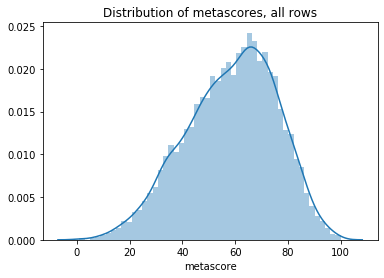

Standard deviation, all rows: 17.233450344938834
Variance, metascore: 297.0138036684564


In [98]:
sns.distplot(df.metascore)
plt.title('Distribution of metascores, all rows')
plt.show()
print(f'Standard deviation, all rows: {np.std(df.metascore)}')
print(f'Variance, metascore: {df.metascore.var()}')

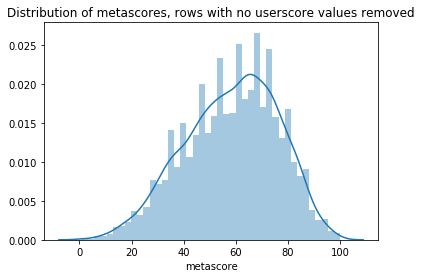

Standard deviation, metascore: 17.82302885471763
Variance, metascore: 317.6905419306275


In [99]:
sns.distplot(df[~df.userscore.isna()].metascore)
plt.title('Distribution of metascores, rows with no userscore values removed')
plt.show()
print(f'Standard deviation, metascore: {np.std(df[~df.userscore.isna()].metascore)}')
print(f'Variance, metascore: {df[~df.userscore.isna()].metascore.var()}')

There is a ~.6 difference in deviation and the variance goes up about 20 after getting rid of the rows with no userscore. 

I'm going to look at the change that removing these rows has on runtime as well. 

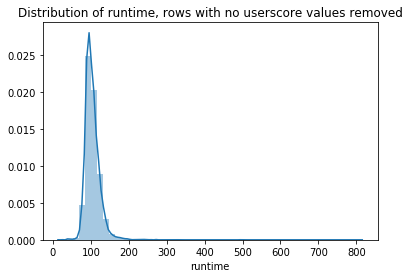

Standard deviation, runtime (no userscore value rows excluded): 20.199836177910097
Variance, runtime (no userscore value rows excluded): 408.06409545570136


In [100]:
sns.distplot(df.runtime)
plt.title('Distribution of runtime, rows with no userscore values removed')
plt.show()
print(f'Standard deviation, runtime (no userscore value rows excluded): {np.std(df.runtime)}')
print(f'Variance, runtime (no userscore value rows excluded): {df.runtime.var()}')

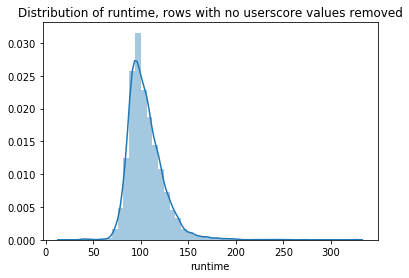

Standard deviation, runtime (no userscore value rows excluded): 18.98481701193426
Variance, runtime (no userscore value rows excluded): 360.45801322151834


In [101]:
sns.distplot(df[~df.userscore.isna()].runtime)
plt.title('Distribution of runtime, rows with no userscore values removed')
plt.show()
print(f'Standard deviation, runtime (no userscore value rows excluded): {np.std(df[~df.userscore.isna()].runtime)}')
print(f'Variance, runtime (no userscore value rows excluded): {df[~df.userscore.isna()].runtime.var()}')

In [102]:
## Getting rid of the rows with no userscore also gets rid of some null runtime rows as well. 
## Since a linear regression model does no handle missing data well I am going to get rid of rows that have a 
## missing userscore or runtime.
df[~df.userscore.isna()].reset_index(drop=True).isna().sum()

movie_title      0
movie_id         0
metascore        0
userscore        0
runtime        148
dtype: int64

In [103]:
df = df[(~df.runtime.isna()) & (~df.userscore.isna())].reset_index(drop=True)
df

movie_title  movie_id  metascore  userscore  runtime
0                          Boyhood     15327        100        7.6    165.0
1                Three Colors: Red     15328        100        8.6     99.0
2                    The Godfather     15329        100        9.2    175.0
3                          Vertigo     15330        100        8.8    128.0
4                      Rear Window     15331        100        8.8    112.0
...                            ...       ...        ...        ...      ...
10372              United Passions     28800          1        0.7    110.0
10373                        Chaos     28801          1        2.3     74.0
10374           The Singing Forest     28802          1        2.0     95.0
10375                     Bio-Dome     28803          1        7.2     88.0
10376  The Garbage Pail Kids Movie     28804          1        0.8    100.0

[10377 rows x 5 columns]

In [41]:
## Using module function to take the average of cast/crew members metacritic scores
## before whatever movie the current row is. This is going to be the main features that 
## will be used that is continuous. I am using postgres DB I created for this so it will 
## be using the other data points that may have been left out by removing null values. 
whole_cast_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                      role='Cast', 
                                                                      cur=cur), 
                                   axis=1)
principle_cast_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                         role='Principle Cast', 
                                                                         cur=cur), 
                                      axis=1)
supporting_cast_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                           role='Cast (non-principle)', 
                                                                           cur=cur), 
                                        axis=1)
director_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                    role='Director', 
                                                                    cur=cur), 
                                 axis=1)
writer_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                  role='Writer', 
                                                                  cur=cur), 
                               axis=1)
producer_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                    role='Producer', cur=cur), 
                                 axis=1)
other_avg = df.progress_apply(lambda x: mt.get_cast_crew_average(row=x, 
                                                                 role='Other', cur=cur), 
                              axis=1)

In [58]:
metascore_running = pd.concat([whole_cast_avg, principle_cast_avg, supporting_cast_avg, director_avg, writer_avg,
                               producer_avg, other_avg], axis=1)

In [125]:
## I wanted to also use the userscore average of cast and crew members
def userscore_average(row, role):
    assert role in ['Principle Cast', 'Cast (non-principle)', 'Cast', 'Director', 'Writer', 'Producer', 'Other'], \
    "The role specified is not an accepted parameter."
    if role == 'Cast':
        role = ('Principle Cast', 'Cast (non-principle)')
    if role == 'Director':
        role = ('Director', 'Co-Director & Producer')
    if role == 'Producer':
        role = ('Producer', 'Executive Producer')
    if role == 'Other':
        role = ('Co-Producer', 'Associate Producer', 'Line Producer ', 'Co-Executive Producer')
    if type(role) is str:
        q = f'''
        SELECT AVG(avg_userscore)
        FROM (SELECT person, AVG(userscore) avg_userscore
              FROM (SELECT c.person, c.label, Scores.userscore
                    FROM cast_crew_credits c
                    LEFT JOIN (SELECT id, userscore
                               FROM metacritic_scores
                               WHERE (userscore <> 'NaN') AND (release_date < (SELECT release_date 
                                                                        FROM metacritic_scores
                                                                        WHERE id = {row.movie_id}))) AS Scores
                    ON c.movie_id = Scores.id
                    WHERE c.label = '{role}' AND person IN (SELECT person 
                                                           FROM cast_crew_credits 
                                                           WHERE movie_id = {row.movie_id})) AS PersonScores 
              GROUP BY person) AS MovieAverage;
              '''
    else:
        q = f'''
        SELECT AVG(avg_userscore)
        FROM (SELECT person, AVG(userscore) avg_userscore
              FROM (SELECT c.person, c.label, Scores.userscore
                    FROM cast_crew_credits c
                    LEFT JOIN (SELECT id, userscore
                               FROM metacritic_scores
                               WHERE (userscore <> 'NaN') AND (release_date < (SELECT release_date 
                                                                           FROM metacritic_scores
                                                                           WHERE id = {row.movie_id}))) AS Scores
                    ON c.movie_id = Scores.id
                    WHERE c.label IN {role} AND person IN (SELECT person 
                                                           FROM cast_crew_credits 
                                                           WHERE movie_id = {row.movie_id})) AS PersonScores 
              GROUP BY person) AS MovieAverage;
              '''
    cur.execute(q, row)
    return cur.fetchone()[0]

In [127]:
principle_cast_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Principle Cast'), axis=1)
support_cast_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Cast (non-principle)'), axis=1)
writer_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Writer'), axis=1)
whole_cast_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Cast'), axis=1)
director_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Director'), axis=1)
producer_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Producer'), axis=1)
other_user_avg = df.progress_apply(lambda x: userscore_average(row=x, role='Other'), axis=1

In [130]:
user_averages = pd.concat([principle_cast_user_avg, support_cast_user_avg, writer_user_avg, whole_cast_user_avg,
                            director_user_avg, producer_user_avg, other_user_avg], axis=1)

In [131]:
user_cols = ['principle_cast_user', 'supporting_cast_user', 'writers_user', 'whole_cast_user', 'director_user', 
             'producer_user', 'others_user']
meta_cols = ['whole_cast_meta', 'principle_cast_meta', 'supporting_cast_meta', 'director_meta', 'writer_meta', 
             'producer_meta', 'others_meta']
metascore_running.columns = meta_cols
user_averages.columns = user_cols 

running_averages = pd.concat([metascore_running, user_averages], axis=1)

In [135]:
## replacing None with null value
running_averages = running_averages.fillna(value=np.nan)
running_averages.head()

whole_cast_meta  principle_cast_meta supporting_cast_meta  \
0  60.9642089093701997  56.1178743961352657  60.1904761904761905   
1  83.0000000000000000  83.0000000000000000                  NaN   
2  79.4770833333333333  79.1770833333333333  91.5000000000000000   
3  76.1836734693877551  76.5646258503401361  79.7500000000000000   
4  82.0666666666666667  82.2800000000000000  80.0000000000000000   

         director_meta          writer_meta        producer_meta  \
0  56.8500000000000000  75.3232323232323232  62.3484984984984985   
1  86.3333333333333333  86.3333333333333333  87.2500000000000000   
2                  NaN  91.0000000000000000  75.0000000000000000   
3  84.0000000000000000  75.8333333333333334  83.2500000000000000   
4  84.0000000000000000  80.6666666666666667  82.8000000000000000   

           others_meta  principle_cast_user  supporting_cast_user  \
0  75.6250000000000000              7.07096              6.487798   
1                  NaN              7.60000                   NaN   
2                  NaN              7.58000              8.450000   
3  76.0000000000000000              8.20400              8.550000   
4                  NaN              8.42000                   NaN   

   writers_user  whole_cast_user  director_user  producer_user  others_user  
0      7.694949         6.651429       7.258333       6.896704          7.7  
1      8.566667         7.600000       8.566667       8.700000          NaN  
2      8.400000         7.848611            NaN       6.500000          NaN  
3      8.383333         8.294000       8.554545       8.625000          9.0  
4      8.066667         8.420000       8.412500       8.440000          NaN

In [136]:
## This is my main set of features that will be used for regression that are continuous. 
## Getting rid of rows where the user averages for director are null get rid of a good amount of the null values.
## After making the rest of the table I'm going to figure out what to do with all the missing values
running_averages.isna().sum()

whole_cast_meta          422
principle_cast_meta     1095
supporting_cast_meta     561
director_meta           2656
writer_meta             2161
producer_meta            975
others_meta             2195
principle_cast_user     1316
supporting_cast_user     696
writers_user            2550
whole_cast_user          533
director_user           3063
producer_user           1204
others_user             2529
dtype: int64

In [148]:
df = pd.concat([df, running_averages], axis=1)

In [151]:
production_companies_series = df.progress_apply(lambda x: mt.get_detail_value(row=x, 
                                                           column='production_companies', 
                                                           table='movie_details', 
                                                           id_='movie_id', cur=cur), axis=1)

In [152]:
languages_series = df.progress_apply(lambda x: ', '.join([lang.strip() for lang in mt.get_detail_value(row=x, 
                                                                          column='languages', 
                                                                          table='movie_details', 
                                                                          id_='movie_id', cur=cur).split(',')]), 
                                     axis=1)

In [153]:
production_companies_series

0                  Detour Filmproduction
1                                 Canal+
2                     Paramount Pictures
3                     Universal Pictures
4        Alfred J. Hitchcock Productions
                      ...               
10372                       Thelma Films
10373             Dominion Entertainment
10374                   A.J. Productions
10375               3 Arts Entertainment
10376       Atlantic Entertainment Group
Length: 10377, dtype: object

In [155]:
languages_series

0               English, Spanish
1                         French
2        English, Italian, Latin
3                        English
4                        English
                  ...           
10372                    English
10373                    English
10374                    English
10375                    English
10376                    English
Length: 10377, dtype: object

In [157]:
genres_series = df.progress_apply(lambda x: mt.get_detail_value(row=x,
                                                             column='genres', 
                                                             table='movie_details', 
                                                             id_='movie_id', cur=cur), axis=1)

In [158]:
mpaa_series = df.progress_apply(lambda x: mt.get_detail_value(row=x, 
                                           column='mpaa_rating', 
                                           table='movie_details', 
                                           id_='movie_id', cur=cur), axis=1)

In [159]:
release_dates = df.progress_apply(lambda x: mt.get_detail_value(row=x, 
                                                    column='release_date', 
                                                    table='metacritic_scores', 
                                                    id_='id', cur=cur), axis=1)

In [163]:
release_dates = pd.to_datetime(release_dates)

In [175]:
release_dates

0       2014-07-11
1       1994-11-23
2       1972-03-11
3       1958-05-28
4       1954-09-01
           ...    
10372   2015-06-05
10373   2005-08-12
10374   2003-11-14
10375   1996-01-12
10376   1987-08-22
Length: 10377, dtype: datetime64[ns]

In [188]:
def get_season(row):
    date = row.strftime('%m-%d')
    if date > '12-21':
        return 'Winter'
    if date < '03-21':
        return 'Winter'
    if date > '09-21':
        return 'Fall'
    if date > '06-21':
        return 'Summer'
    return 'Spring'

def time_of_month(row):
    date = row.strftime('%d')
    if date > '20':
        return 'End'
    if date > '10':
        return 'Middle'
    return 'Beginning'

In [184]:
seasons = release_dates.apply(lambda x: get_season(x))

In [190]:
release_time_of_month = release_dates.apply(lambda x: time_of_month(x))

In [192]:
release_info = pd.concat([seasons, release_time_of_month], axis=1)
release_info.columns = ['rls_season', 'rls_time_of_month']

In [195]:
categorical = pd.concat([mpaa_series, genres_series, languages_series, production_companies_series], axis=1)
categorical.columns = ['mpaa', 'genre', 'language', 'production_companies']
categorical.head()

mpaa                                              genre  \
0    R                                              Drama   
1    R  Drama,                                        ...   
2    R  Drama,                                        ...   
3   PG  Mystery,                                      ...   
4    G  Mystery,                                      ...   

                  language             production_companies  
0         English, Spanish            Detour Filmproduction  
1                   French                           Canal+  
2  English, Italian, Latin               Paramount Pictures  
3                  English               Universal Pictures  
4                  English  Alfred J. Hitchcock Productions

In [197]:
df = pd.concat([df, release_info, categorical], axis=1)

In [199]:
df.head()

movie_title  movie_id  metascore  userscore  runtime  \
0            Boyhood     15327        100        7.6    165.0   
1  Three Colors: Red     15328        100        8.6     99.0   
2      The Godfather     15329        100        9.2    175.0   
3            Vertigo     15330        100        8.8    128.0   
4        Rear Window     15331        100        8.8    112.0   

       whole_cast_meta  principle_cast_meta supporting_cast_meta  \
0  60.9642089093701997  56.1178743961352657  60.1904761904761905   
1  83.0000000000000000  83.0000000000000000                  NaN   
2  79.4770833333333333  79.1770833333333333  91.5000000000000000   
3  76.1836734693877551  76.5646258503401361  79.7500000000000000   
4  82.0666666666666667  82.2800000000000000  80.0000000000000000   

         director_meta          writer_meta  ... whole_cast_user  \
0  56.8500000000000000  75.3232323232323232  ...        6.651429   
1  86.3333333333333333  86.3333333333333333  ...        7.600000   
2                  NaN  91.0000000000000000  ...        7.848611   
3  84.0000000000000000  75.8333333333333334  ...        8.294000   
4  84.0000000000000000  80.6666666666666667  ...        8.420000   

  director_user  producer_user  others_user  rls_season  rls_time_of_month  \
0      7.258333       6.896704          7.7      Summer             Middle   
1      8.566667       8.700000          NaN        Fall                End   
2           NaN       6.500000          NaN      Winter             Middle   
3      8.554545       8.625000          9.0      Spring                End   
4      8.412500       8.440000          NaN      Summer          Beginning   

   mpaa                                              genre  \
0     R                                              Drama   
1     R  Drama,                                        ...   
2     R  Drama,                                        ...   
3    PG  Mystery,                                      ...   
4     G  Mystery,                                      ...   

                  language             production_companies  
0         English, Spanish            Detour Filmproduction  
1                   French                           Canal+  
2  English, Italian, Latin               Paramount Pictures  
3                  English               Universal Pictures  
4                  English  Alfred J. Hitchcock Productions  

[5 rows x 25 columns]

In [201]:
## After working the missing data I will make dummy variables for the last six columns.
df.isna().sum()

movie_title                0
movie_id                   0
metascore                  0
userscore                  0
runtime                    0
whole_cast_meta          422
principle_cast_meta     1095
supporting_cast_meta     561
director_meta           2656
writer_meta             2161
producer_meta            975
others_meta             2195
principle_cast_user     1316
supporting_cast_user     696
writers_user            2550
whole_cast_user          533
director_user           3063
producer_user           1204
others_user             2529
rls_season                 0
rls_time_of_month          0
mpaa                       0
genre                      0
language                   0
production_companies       0
dtype: int64

In [204]:
## I'm dropping the others column for userscore and metascores and get rid of rows that don't have a userscore avg
df[~df.director_user.isna()].isna().sum()

movie_title                0
movie_id                   0
metascore                  0
userscore                  0
runtime                    0
whole_cast_meta           91
principle_cast_meta      365
supporting_cast_meta     165
director_meta              0
writer_meta              411
producer_meta            156
others_meta              952
principle_cast_user      449
supporting_cast_user     206
writers_user             543
whole_cast_user          113
director_user              0
producer_user            216
others_user             1125
rls_season                 0
rls_time_of_month          0
mpaa                       0
genre                      0
language                   0
production_companies       0
dtype: int64

In [208]:
df = df.drop(columns=['others_meta', 'others_user'])
df = df[~df.director_user.isna()].reset_index(drop=True)

In [210]:
## I have called the non-principle cast members columns supporting cast, but on the Metacritic site, if a movie
## doesn't have a specified principle cast then all the members of the cast are just listed under the table where
## supporting cast would be if there was a principle cast to support. This is where there are so few whole_cast 
## null values in comparison to the principle and supporting cast nulls.
df.isna().sum()

movie_title               0
movie_id                  0
metascore                 0
userscore                 0
runtime                   0
whole_cast_meta          91
principle_cast_meta     365
supporting_cast_meta    165
director_meta             0
writer_meta             411
producer_meta           156
principle_cast_user     449
supporting_cast_user    206
writers_user            543
whole_cast_user         113
director_user             0
producer_user           216
rls_season                0
rls_time_of_month         0
mpaa                      0
genre                     0
language                  0
production_companies      0
dtype: int64

In [216]:
## If I only used the whole cast columns then it would leave still a lot of null values to deal with due 
## to writers and directors. It would also decrease the amount of features I'd have to work with. 
option_one.isna().sum()

movie_title               0
movie_id                  0
metascore                 0
userscore                 0
runtime                   0
whole_cast_meta          91
director_meta             0
writer_meta             411
producer_meta           156
writers_user            543
whole_cast_user         113
director_user             0
producer_user           216
rls_season                0
rls_time_of_month         0
mpaa                      0
genre                     0
language                  0
production_companies      0
dtype: int64

In [220]:
print(df.shape)
df.isna().sum()

(7314, 23)


movie_title               0
movie_id                  0
metascore                 0
userscore                 0
runtime                   0
whole_cast_meta          91
principle_cast_meta     365
supporting_cast_meta    165
director_meta             0
writer_meta             411
producer_meta           156
principle_cast_user     449
supporting_cast_user    206
writers_user            543
whole_cast_user         113
director_user             0
producer_user           216
rls_season                0
rls_time_of_month         0
mpaa                      0
genre                     0
language                  0
production_companies      0
dtype: int64

In [225]:
## If i just dropped rows with null values then I would be left with a little more than 6000 data entries, only 
## a little more than a thousand fewer with all null rows.
print(df.dropna().reset_index(drop=True).shape)
df = df.dropna().reset_index(drop=True)

(6228, 23)


In [226]:
df

movie_title  movie_id  metascore  \
0                                      Boyhood     15327        100   
1                                      Vertigo     15330        100   
2                                    Notorious     15332        100   
3                                    Moonlight     15335         99   
4                                Touch of Evil     15336         99   
...                                        ...       ...        ...   
6223                                   Screwed     28791          7   
6224                             Baby Geniuses     28794          6   
6225  The Human Centipede III (Final Sequence)     28795          5   
6226                                    Vulgar     28796          5   
6227                           United Passions     28800          1   

      userscore  runtime      whole_cast_meta  principle_cast_meta  \
0           7.6    165.0  60.9642089093701997  56.1178743961352657   
1           8.8    128.0  76.1836734693877551  76.5646258503401361   
2           8.0    101.0  86.5000000000000000  85.2000000000000000   
3           7.2    111.0  59.6195932539682540  62.1565040650406504   
4           8.4     95.0  83.7083333333333333  87.1666666666666667   
...         ...      ...                  ...                  ...   
6223        8.1     81.0  38.5343915343915344  37.8154761904761905   
6224        3.1     97.0  56.8155154299891142  58.4808080808080808   
6225        2.5    102.0  50.2851762820512821  43.4000000000000000   
6226        2.4     87.0  63.4428571428571429  60.5000000000000000   
6227        0.7    110.0  52.5876737524820829  56.6410678137651822   

     supporting_cast_meta        director_meta          writer_meta  ...  \
0     60.1904761904761905  56.8500000000000000  75.3232323232323232  ...   
1     79.7500000000000000  84.0000000000000000  75.8333333333333334  ...   
2     93.3333333333333333  84.0000000000000000  78.8125000000000000  ...   
3     59.1729166666666667  63.0000000000000000  63.0000000000000000  ...   
4     83.5000000000000000  89.6666666666666667  91.5000000000000000  ...   
...                   ...                  ...                  ...  ...   
6223  41.8585034013605442  64.2500000000000000  41.3333333333333333  ...   
6224  56.3638888888888889  46.5000000000000000  54.3888888888888889  ...   
6225  51.4897435897435897  25.0000000000000000  25.0000000000000000  ...   
6226  64.9095238095238095  59.0000000000000000  59.0000000000000000  ...   
6227  52.0163389242336611  62.4166666666666667  39.0000000000000000  ...   

     writers_user  whole_cast_user  director_user  producer_user  rls_season  \
0        7.694949         6.651429       7.258333       6.896704      Summer   
1        8.383333         8.294000       8.554545       8.625000      Spring   
2        8.216667         8.285000       8.400000       8.500000      Summer   
3        6.400000         7.023002       6.400000       6.687326        Fall   
4        8.325000         8.362500       8.300000       8.350000      Winter   
...           ...              ...            ...            ...         ...   
6223     7.600000         7.493445       7.825000       7.288889      Spring   
6224     8.050000         7.714392       7.766667       7.655556      Winter   
6225     3.600000         5.998593       3.600000       3.600000      Spring   
6226     8.580000         8.406429       8.580000       8.590000      Spring   
6227     5.200000         6.733806       7.312500       6.018651      Spring   

      rls_time_of_month      mpaa  \
0                Middle         R   
1                   End        PG   
2             Beginning  Approved   
3                   End        NR   
4             Beginning      PG13   
...                 ...       ...   
6223             Middle      PG13   
6224             Middle        PG   
6225                End        NR   
6226                End         R   
6227          Beginning        NR   

                      

In [227]:
## saving for data analysis and visualization
df.to_csv('df-no-dummies.csv', index=False)

# Making dummy variables

Below I am going to work with the features that I extracted above. In the case of languages, genres, and mpaa ratings I will be merging together some of the dummy variables into compressed features that are still simillar. That way rather than 225 dummies of languages or 28 for genre there will be fewer thereby giving slightly higher significance to statistical output.

In [233]:
language_dummies = df.language.str.get_dummies(sep=', ')
language_dummies.head()

Aboriginal  Afrikaans  Albanian  Algonquin  American Sign Language  \
0           0          0         0          0                       0   
1           0          0         0          0                       0   
2           0          0         0          0                       0   
3           0          0         0          0                       0   
4           0          0         0          0                       0   

   Amharic  Apache languages  Arabic  Aramaic  Armenian  ...  qab  qac  qae  \
0        0                 0       0        0         0  ...    0    0    0   
1        0                 0       0        0         0  ...    0    0    0   
2        0                 0       0        0         0  ...    0    0    0   
3        0                 0       0        0         0  ...    0    0    0   
4        0                 0       0        0         0  ...    0    0    0   

   qba  qbc  qbo  rom  scn  sio  yue  
0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0  

[5 rows x 157 columns]

In [235]:
language_dummies.sum(axis=0).reset_index().sort_values(0, ascending=False).head(10)

index     0
30      English  5808
36       French   640
117     Spanish   463
42       German   309
57      Italian   222
102     Russian   212
58     Japanese   195
7        Arabic   120
72     Mandarin   114
95   Portuguese    62

In [236]:
top_lang = ['English', 'Spanish', 'French', 'German', 'Italian', 'Russian', 'Japanese']
alone_languages = language_dummies[top_lang]
rest = language_dummies.drop(columns=top_lang)

In [237]:
other_langs = rest.apply(lambda x: mt.dummies_helper(x), axis=1)
other_langs

0       0
1       0
2       1
3       0
4       0
       ..
6223    0
6224    0
6225    0
6226    0
6227    0
Length: 6228, dtype: int64

In [238]:
languages_df = pd.concat([alone_languages, other_langs], axis=1)
languages_df.columns = ['lang_english', 'lang_spanish', 'lang_french', 'lang_german', 
                        'lang_italian', 'lang_russian', 'lang_japanese', 'lang_others']

In [239]:
languages_df.sum(axis=0)

lang_english     5808
lang_spanish      463
lang_french       640
lang_german       309
lang_italian      222
lang_russian      212
lang_japanese     195
lang_others       987
dtype: int64

In [243]:
# So many spaces
df.genre.head()

0                                                Drama
1    Mystery,                                      ...
2    Drama,                                        ...
3                                                Drama
4    Drama,                                        ...
Name: genre, dtype: object

In [254]:
genres_df = df.genre.apply(lambda x: x.replace(' ', '')).str.get_dummies(sep=',')
print(genres_df.shape)
genres_df.head()

(6228, 25)


Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  Drama  \
0       0          0          0          0       0      0            0      1   
1       0          0          0          0       0      0            0      0   
2       0          0          0          0       0      0            0      1   
3       0          0          0          0       0      0            0      1   
4       0          0          0          0       0      1            0      1   

   Family  Fantasy  ...  Mystery  NaN  News  Romance  Sci-Fi  Short  Sport  \
0       0        0  ...        0    0     0        0       0      0      0   
1       0        0  ...        1    0     0        1       0      0      0   
2       0        0  ...        0    0     0        1       0      0      0   
3       0        0  ...        0    0     0        0       0      0      0   
4       0        0  ...        0    0     0        0       0      0      0   

   Thriller  War  Western  
0         0    0        0  
1         1    0        0  
2         1    0        0  
3         0    0        0  
4         1    0        0  

[5 rows x 25 columns]

In [255]:
action_adventure = genres_df[['Western', 'War', 'Sci-Fi', 'Sport', 'Fantasy', 'Action', 'Adventure', 'History']].apply(lambda x: mt.dummies_helper(x), axis=1)
suspense = genres_df[['Thriller', 'Horror', 'Crime', 'Film-Noir', 'Mystery']].apply(lambda x: mt.dummies_helper(x), axis=1)
others = genres_df[['Romance', 'Short', 'NaN', 'Music', 'Musical', 'Animation', 'Family', 'News', 'Documentary', 'Biography']].apply(lambda x: mt.dummies_helper(x), axis=1)

In [256]:
gens = genres_df.drop(columns=['News', 'Documentary', 'Biography', 'Western', 'War', 
                                 'Sci-Fi', 'Sport', 'Fantasy', 'Action', 'Adventure', 'History', 'Thriller', 
                                 'Horror', 'Crime','Romance', 'Short', 'NaN', 'Music', 'Musical', 
                                 'Film-Noir', 'Mystery', 'Animation', 'Family'])
gens.head()

Comedy  Drama
0       0      1
1       0      0
2       0      1
3       0      1
4       0      1

In [257]:
columns = ['genre_comedy', 'genre_drama', 'genre_action_adv', 'genre_suspense', 'genre_others']

In [258]:
genres_df = pd.concat([gens, action_adventure, suspense, others], axis=1)
genres_df.columns = columns
genres_df.head()

genre_comedy  genre_drama  genre_action_adv  genre_suspense  genre_others
0             0            1                 0               0             0
1             0            0                 0               1             1
2             0            1                 0               1             1
3             0            1                 0               0             0
4             0            1                 0               1             0

In [259]:
# Distribution of genres
genres_df.sum()

genre_comedy        2195
genre_drama         3431
genre_action_adv    2644
genre_suspense      2524
genre_others        2477
dtype: int64

In [ ]:
mpaa_dummies = mpaa_series.str.get_dummies()
pre_mpaa_ratings = mpaa_dummies[['Approved', 'Passed']].apply(lambda x: mt.dummies_helper(x), axis=1)
mpaa_df = mpaa_dummies.drop(columns=['Approved', 'Passed'])
mpaa_df['Approved/Passed'] = pre_mpaa_ratings
mpaa_df.head()

In [263]:
## All I'm going to do here is group together Passed and Approved because they are outdated, MPAA ratings aren't 
## given those ratings any longer.  
print(df.mpaa.unique())
print(df.mpaa.shape)
df.mpaa.head()

['R' 'PG' 'Approved' 'NR' 'PG13' 'G' 'Passed' 'NC17']
(6228,)


0           R
1          PG
2    Approved
3          NR
4        PG13
Name: mpaa, dtype: object

In [265]:
mpaa = df.mpaa.str.get_dummies()
mpaa.head()

Approved  G  NC17  NR  PG  PG13  Passed  R
0         0  0     0   0   0     0       0  1
1         0  0     0   0   1     0       0  0
2         1  0     0   0   0     0       0  0
3         0  0     0   1   0     0       0  0
4         0  0     0   0   0     1       0  0

In [269]:
mpaa['approved_passed'] = mpaa[['Approved', 'Passed']].apply(lambda x: mt.dummies_helper(x), axis=1)
mpaa = mpaa.drop(columns=['Approved', 'Passed'])

In [270]:
mpaa

G  NC17  NR  PG  PG13  R  approved_passed
0     0     0   0   0     0  1                0
1     0     0   0   1     0  0                0
2     0     0   0   0     0  0                1
3     0     0   1   0     0  0                0
4     0     0   0   0     1  0                0
...  ..   ...  ..  ..   ... ..              ...
6223  0     0   0   0     1  0                0
6224  0     0   0   1     0  0                0
6225  0     0   1   0     0  0                0
6226  0     0   0   0     0  1                0
6227  0     0   1   0     0  0                0

[6228 rows x 7 columns]

In [275]:
## For now I am going to exclude production companies from my table for analysis.
len(df.production_companies.unique())

1583

In [283]:
## adding in the dummies for the season of year the film was release as well as the time of month
dummies = pd.concat([mpaa, genres_df, languages_df, df.rls_season.str.get_dummies(), 
                     df.rls_time_of_month.str.get_dummies()], axis=1)

In [400]:
# drop the columns that are categorical 
df = df.drop(columns=['movie_id', 'rls_season', 'rls_time_of_month', 'mpaa', 'genre', 'language', 'production_companies'])
# concat the df with dummies
df = pd.concat([df, dummies], axis=1)
df.head()

movie_title  metascore  userscore  runtime  whole_cast_meta  \
0        Boyhood        100        7.6    165.0        60.964209   
1        Vertigo        100        8.8    128.0        76.183673   
2      Notorious        100        8.0    101.0        86.500000   
3      Moonlight         99        7.2    111.0        59.619593   
4  Touch of Evil         99        8.4     95.0        83.708333   

   principle_cast_meta  supporting_cast_meta  director_meta  writer_meta  \
0            56.117874             60.190476      56.850000    75.323232   
1            76.564626             79.750000      84.000000    75.833333   
2            85.200000             93.333333      84.000000    78.812500   
3            62.156504             59.172917      63.000000    63.000000   
4            87.166667             83.500000      89.666667    91.500000   

   producer_meta  ...  lang_russian  lang_japanese  lang_others  Fall  Spring  \
0      62.348498  ...             0              0            0     0       0   
1      83.250000  ...             0              0            0     0       1   
2      78.000000  ...             0              0            1     0       0   
3      68.903478  ...             0              0            0     1       0   
4      88.000000  ...             0              0            0     0       0   

   Summer  Winter  Beginning  End  Middle  
0       1       0          0    0       1  
1       0       0          0    1       0  
2       1       0          1    0       0  
3       0       0          0    1       0  
4       0       1          1    0       0  

[5 rows x 43 columns]

Userscore is out of ten and metascore is out of 100. I am going to multiply all of the userscore columns by 10 so that it can be on the same scale as the metascore. 

In [401]:
for i in ['userscore'] + list(df.columns[9:15]):
    df[i] = df[i] * 10
df.head()

movie_title  metascore  userscore  runtime  whole_cast_meta  \
0        Boyhood        100       76.0    165.0        60.964209   
1        Vertigo        100       88.0    128.0        76.183673   
2      Notorious        100       80.0    101.0        86.500000   
3      Moonlight         99       72.0    111.0        59.619593   
4  Touch of Evil         99       84.0     95.0        83.708333   

   principle_cast_meta  supporting_cast_meta  director_meta  writer_meta  \
0            56.117874             60.190476      56.850000    75.323232   
1            76.564626             79.750000      84.000000    75.833333   
2            85.200000             93.333333      84.000000    78.812500   
3            62.156504             59.172917      63.000000    63.000000   
4            87.166667             83.500000      89.666667    91.500000   

   producer_meta  ...  lang_russian  lang_japanese  lang_others  Fall  Spring  \
0     623.484985  ...             0              0            0     0       0   
1     832.500000  ...             0              0            0     0       1   
2     780.000000  ...             0              0            1     0       0   
3     689.034783  ...             0              0            0     1       0   
4     880.000000  ...             0              0            0     0       0   

   Summer  Winter  Beginning  End  Middle  
0       1       0          0    0       1  
1       0       0          0    1       0  
2       1       0          1    0       0  
3       0       0          0    1       0  
4       0       1          1    0       0  

[5 rows x 43 columns]

# Feature Selection

In [402]:
# the movie title is not important
df = df.drop(columns=['movie_title'])

In [588]:
# I need to drop one dummy variable from each of the sets of dummies. This is to ensure 
# there are not too many parameters to estimate when an intercept is also included.
# A dropped dummy is still taken into account when all variables for a set are at zero.

df = df.drop(columns=['G', 'genre_others', 'lang_others', 'Fall', 'Beginning'])

In [5]:
df = pd.read_csv('df-for-analysis.csv')

In [589]:
df.isna().sum()

metascore               0
userscore               0
runtime                 0
whole_cast_meta         0
principle_cast_meta     0
supporting_cast_meta    0
director_meta           0
writer_meta             0
producer_meta           0
principle_cast_user     0
supporting_cast_user    0
writers_user            0
whole_cast_user         0
director_user           0
producer_user           0
NC17                    0
NR                      0
PG                      0
PG13                    0
R                       0
approved_passed         0
genre_comedy            0
genre_drama             0
genre_action_adv        0
genre_suspense          0
lang_english            0
lang_spanish            0
lang_french             0
lang_german             0
lang_italian            0
lang_russian            0
lang_japanese           0
Spring                  0
Summer                  0
Winter                  0
End                     0
Middle                  0
dtype: int64

In [590]:
df.describe()

metascore    userscore      runtime  whole_cast_meta  \
count  6228.000000  6228.000000  6228.000000      6228.000000   
mean     56.997431    66.403179   107.611593        57.387392   
std      17.477444    14.371746    19.082207         7.315304   
min       1.000000     6.000000    21.000000        27.172619   
25%      45.000000    58.000000    94.000000        52.566990   
50%      58.000000    68.000000   105.000000        56.580282   
75%      70.000000    77.000000   117.000000        61.147544   
max     100.000000   100.000000   325.000000        99.000000   

       principle_cast_meta  supporting_cast_meta  director_meta  writer_meta  \
count          6228.000000           6228.000000    6228.000000  6228.000000   
mean             58.335748             57.312823      59.781004    59.659642   
std               8.396998              7.701555      12.355752    12.053544   
min              25.000000             22.914773      10.000000     1.000000   
25%              53.189236             52.188379      52.200000    52.204762   
50%              57.719051             56.250826      60.605556    60.091667   
75%              62.419405             61.117857      68.000000    67.561667   
max              97.666667            100.000000     100.000000   100.000000   

       producer_meta  principle_cast_user  ...  lang_french  lang_german  \
count    6228.000000          6228.000000  ...  6228.000000  6228.000000   
mean      574.601129            69.978761  ...     0.102762     0.049615   
std        98.808478             6.150425  ...     0.303672     0.217165   
min       140.000000            34.000000  ...     0.000000     0.000000   
25%       506.923493            66.109232  ...     0.000000     0.000000   
50%       568.667049            69.984896  ...     0.000000     0.000000   
75%       636.158288            74.000000  ...     0.000000     0.000000   
max      1000.000000            94.000000  ...     1.000000     1.000000   

       lang_italian  lang_russian  lang_japanese       Spring       Summer  \
count   6228.000000   6228.000000    6228.000000  6228.000000  6228.000000   
mean       0.035645      0.034040       0.031310     0.246628     0.257547   
std        0.185420      0.181346       0.174169     0.431083     0.437318   
min        0.000000      0.000000       0.000000     0.000000     0.000000   
25%        0.000000      0.000000       0.000000     0.000000     0.000000   
50%        0.000000      0.000000       0.000000     0.000000     0.000000   
75%        0.000000      0.000000       0.000000     0.000000     1.000000   
max        1.000000      1.000000       1.000000     1.000000     1.000000   

            Winter          End       Middle  
count  6228.000000  6228.000000  6228.000000  
mean      0.207129     0.346500     0.347945  
std       0.405281     0.475893     0.476357  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       0.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000  

[8 rows x 37 columns]

In [591]:
# initial look for correlations
df.corr()

metascore  userscore   runtime  whole_cast_meta  \
metascore              1.000000   0.522103  0.223664         0.488203   
userscore              0.522103   1.000000  0.196321         0.284621   
runtime                0.223664   0.196321  1.000000         0.169205   
whole_cast_meta        0.488203   0.284621  0.169205         1.000000   
principle_cast_meta    0.440571   0.226437  0.152208         0.762466   
supporting_cast_meta   0.424624   0.276954  0.166514         0.916924   
director_meta          0.472434   0.263672  0.186381         0.512654   
writer_meta            0.459968   0.250493  0.158970         0.523696   
producer_meta          0.517093   0.282106  0.135424         0.605035   
principle_cast_user    0.193230   0.253209  0.115400         0.416594   
supporting_cast_user   0.178098   0.296162  0.127227         0.512818   
writers_user           0.188710   0.246497  0.142947         0.271074   
whole_cast_user        0.212677   0.319436  0.141073         0.573400   
director_user          0.168129   0.231935  0.132600         0.231658   
producer_user          0.243613   0.308417  0.149225         0.365609   
NC17                  -0.009395   0.016725  0.003406         0.047358   
NR                     0.196389  -0.008438 -0.073967         0.226200   
PG                    -0.021703   0.020257 -0.073349         0.021443   
PG13                  -0.155639  -0.046851  0.094923        -0.160447   
R                     -0.010917   0.016509  0.048679        -0.078124   
approved_passed        0.073858   0.040335  0.011816         0.180519   
genre_comedy          -0.127842  -0.064083 -0.230901        -0.149736   
genre_drama            0.199303   0.127696  0.243190         0.133944   
genre_action_adv      -0.082611   0.010602  0.126224        -0.056336   
genre_suspense        -0.142464  -0.055067  0.044897        -0.096123   
lang_english          -0.201543  -0.079113 -0.054298        -0.312306   
lang_spanish           0.048550   0.044097  0.085997         0.053132   
lang_french            0.137844   0.053280  0.123451         0.206085   
lang_german            0.057153   0.035834  0.139356         0.091803   
lang_italian           0.032536   0.023774  0.094326         0.073907   
lang_russian           0.027084   0.004839  0.126429         0.044910   
lang_japanese          0.049301   0.040315  0.093631         0.110958   
Spring                -0.018204  -0.026084 -0.036476        -0.008616   
Summer                 0.009247  -0.016652 -0.046051        -0.015172   
Winter                -0.082586  -0.033254 -0.014016        -0.016112   
End                   -0.023043  -0.007492  0.001524         0.009032   
Middle                 0.026900   0.007561  0.041105        -0.013682   

                      principle_cast_meta  supporting_cast_meta  \
metascore                        0.440571              0.424624   
userscore                        0.226437              0.276954   
runtime                          0.152208              0.166514   
whole_cast_meta                  0.762466              0.916924   
principle_cast_meta              1.000000              0.580357   
supporting_cast_meta             0.580357              1.000000   
director_meta                    0.436954              0.471978   
writer_meta                      0.452679              0.483897   
producer_meta                    0.521844              0.558358   
principle_cast_user              0.470772              0.370372   
supporting_cast_user             0.281863              0.590235   
writers_user                     0.199611              0.274169   
whole_cast_user                  0.374533              0.590386   
director_user                    0.165292              0.240719   
producer_user                    0.269119              0.380208   
NC17                             0.024936              0.057777   
NR                               0.228590              0.169652   
PG                              -0.006925

In [592]:
df.var()

metascore                305.461050
userscore                206.547072
runtime                  364.130632
whole_cast_meta           53.513674
principle_cast_meta       70.509576
supporting_cast_meta      59.313948
director_meta            152.664607
writer_meta              145.287913
producer_meta           9763.115248
principle_cast_user       37.827729
supporting_cast_user      33.687386
writers_user              84.009022
whole_cast_user           28.350268
director_user             90.726435
producer_user              0.505298
NC17                       0.004158
NR                         0.136327
PG                         0.102752
PG13                       0.197973
R                          0.244271
approved_passed            0.002403
genre_comedy               0.228263
genre_drama                0.247449
genre_action_adv           0.244344
genre_suspense             0.241064
lang_english               0.062900
lang_spanish               0.068826
lang_french                0

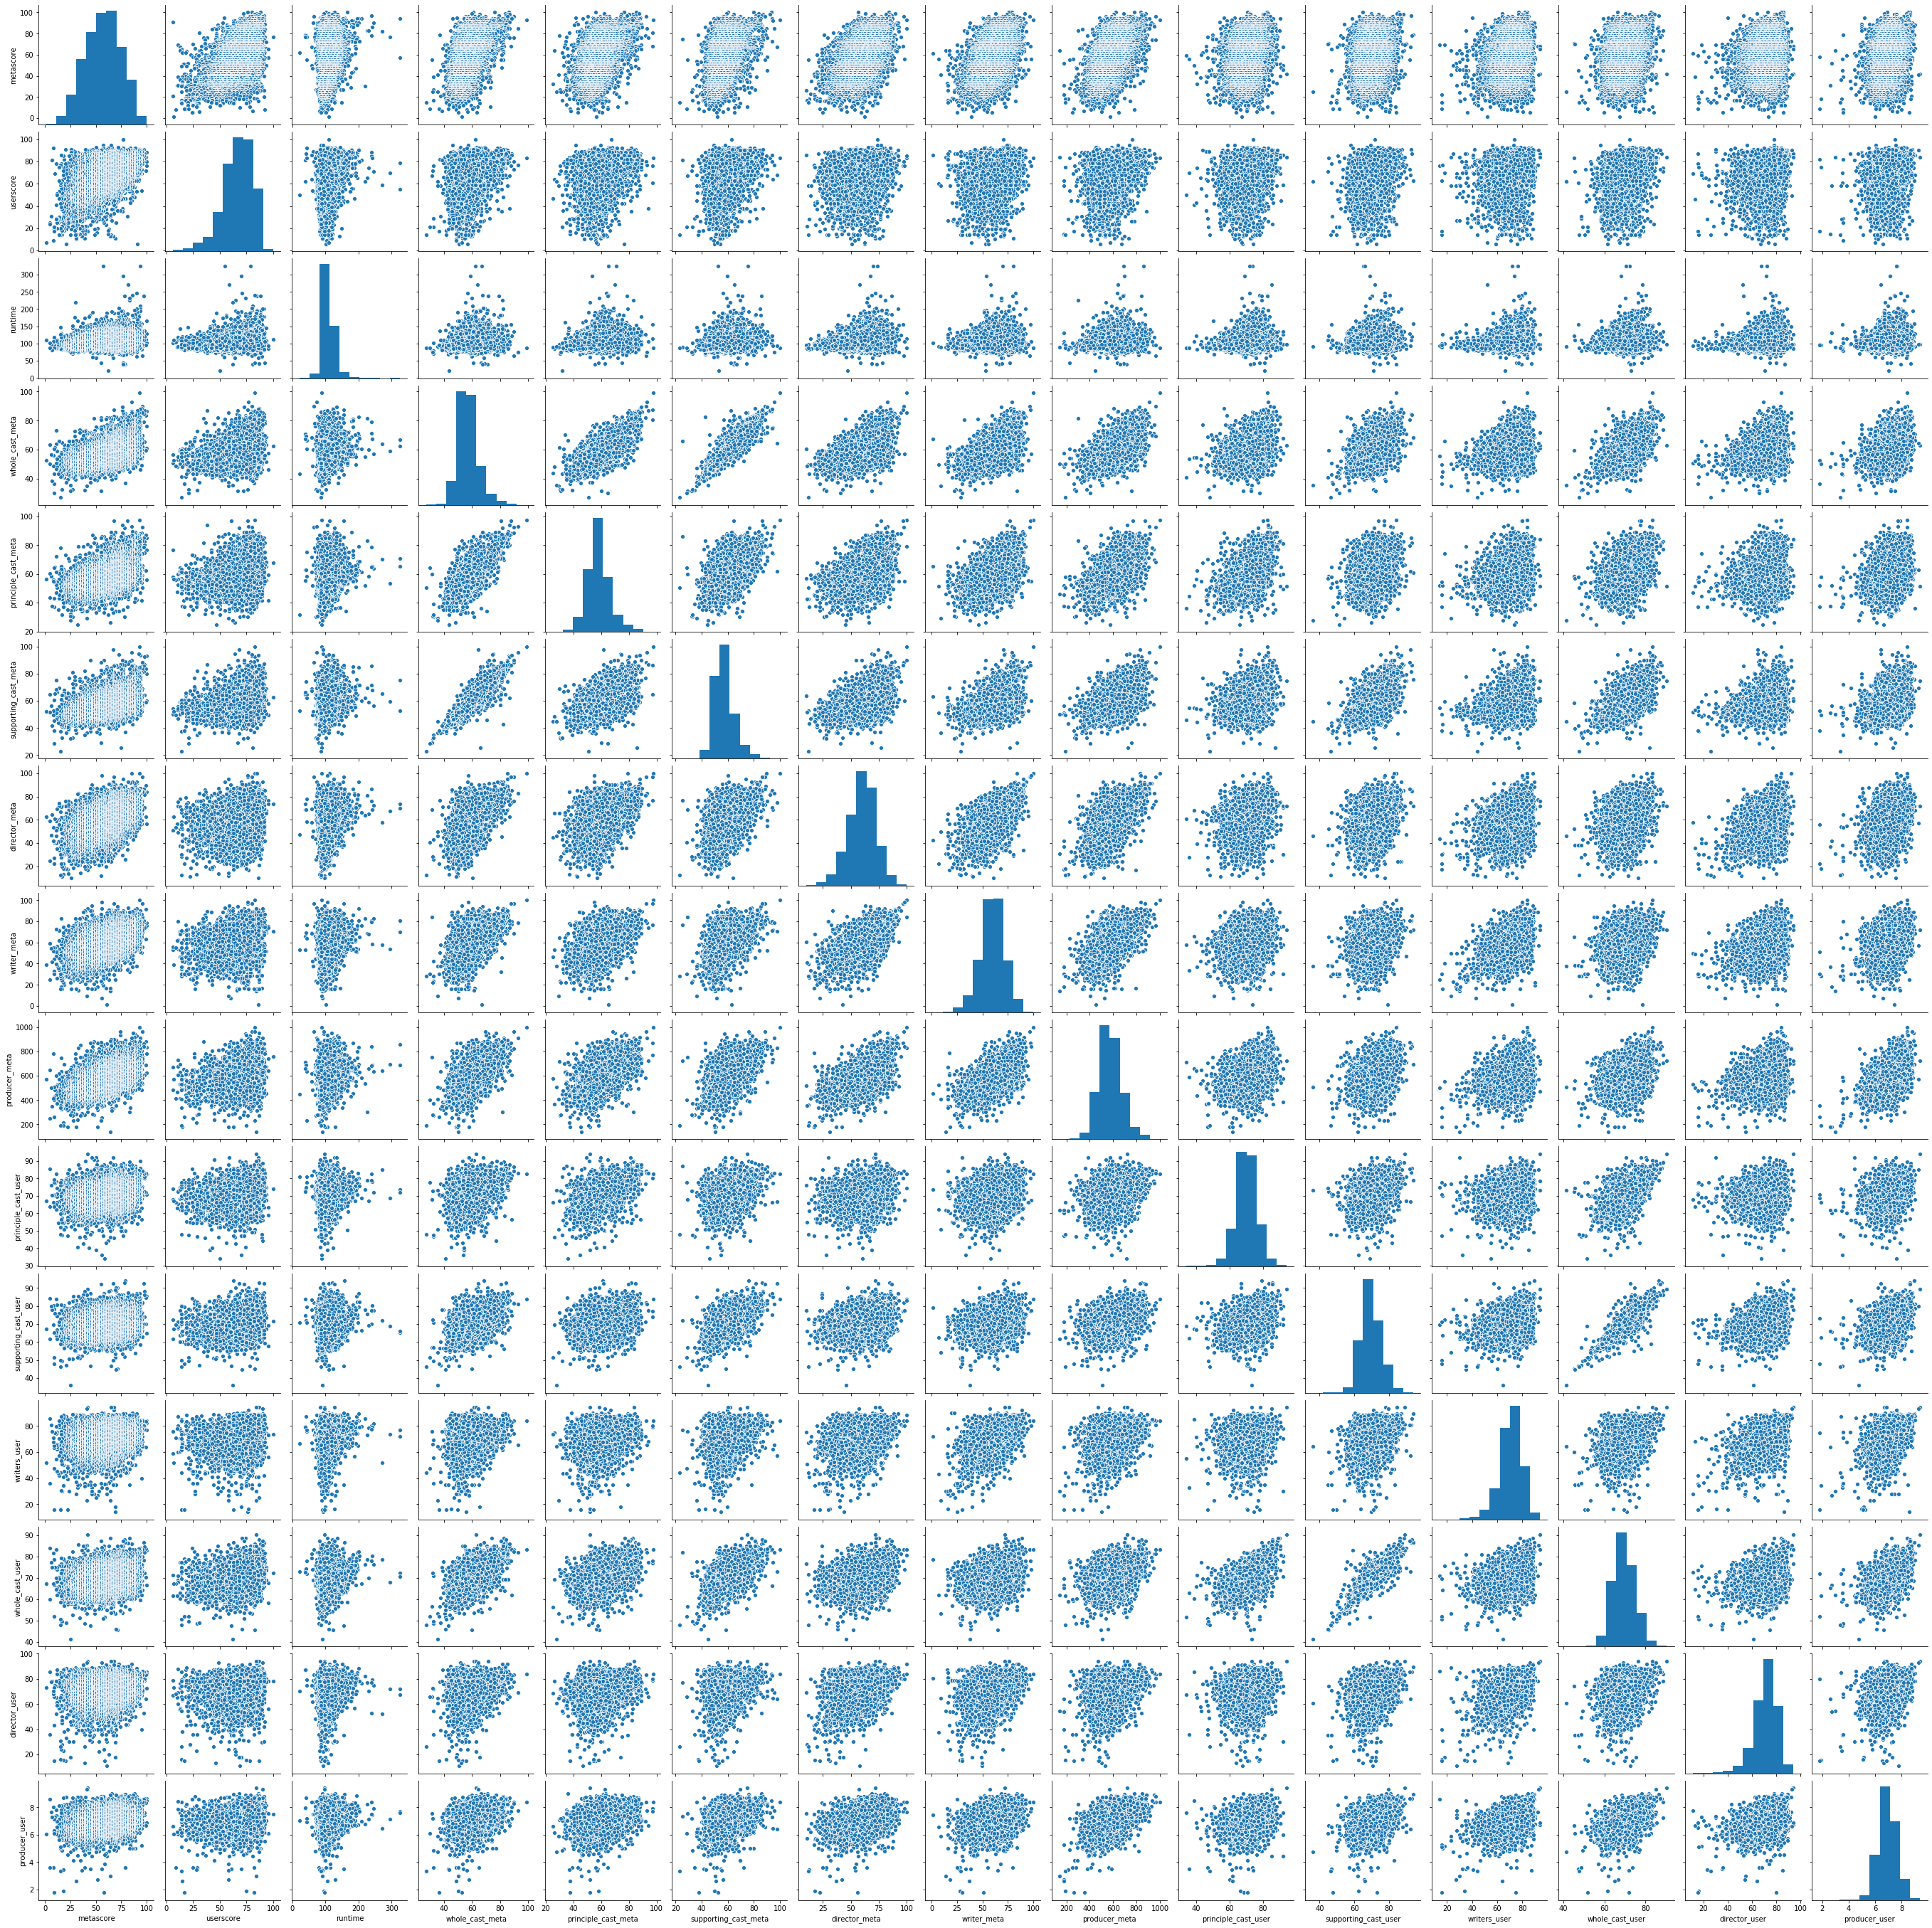

In [407]:
sns.pairplot(df[df.columns[:15]])

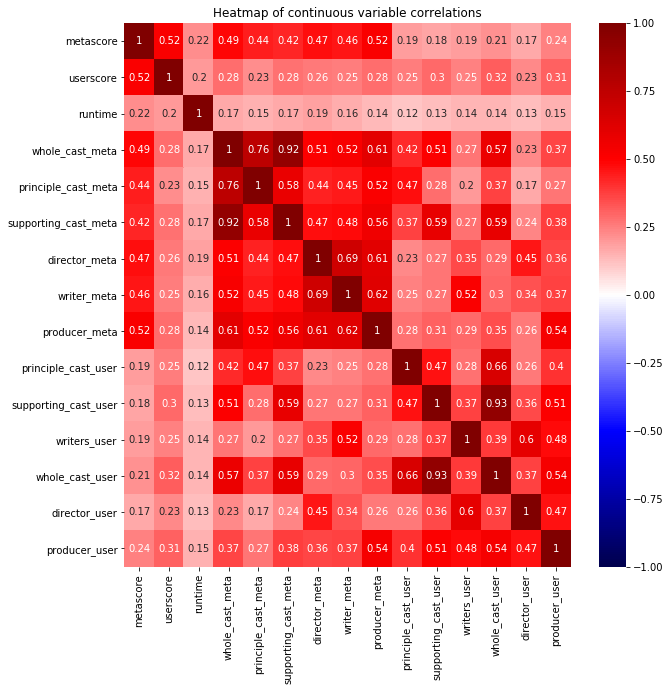

In [594]:
plt.figure(figsize=(10,10))
sns.heatmap(df[df.columns[:15]].corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)
plt.title('Heatmap of continuous variable correlations')
plt.show()

The heatmap above shows that there is strong multicolinearity amoung the rolling average variables. 

I am going to look for feature importance for the entire set of features using three methods to chose features for analysis.

I'm going to use StatsModel to do a linear regression to see how the model looks before feature selection.

In [6]:
X = df[df.columns[1:]]
Y = df.metascore

## running OLS regression from StatsModels API for summary statistics
model.linear_regression_summary(X, Y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     186.3
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:02   Log-Likelihood:                -24369.
No. Observations:                6228   AIC:                         4.881e+04
Df Residuals:                    6191   BIC:                         4.906e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   56.9974      0.154    370.411      0.000      56.696      57.299
userscore                6.9344      0.170     40.792      0.000       6.601       7.268
runtime                  1.4752      0.175      8.431      0.000       1.132       1.818
whole_cast_meta          3.8945      0.604      6.450      0.000       2.711       5.078
principle_cast_meta      0.8673      0.296      2.929      0.003       0.287       1.448
supporting_cast_meta    -0.9913      0.484     -2.048      0.041      -1.940      -0.042
director_meta            1.9412      0.248      7.833      0.000       1.455       2.427
writer_meta              1.6421      0.259      6.342      0.000       1.134       2.150
producer_meta            3.2994      0.255     12.919      0.000       2.799       3.800
principle_cast_user     -0.3231      0.255     -1.266      0.206      -0.824       0.177
supporting_cast_user    -0.5185      0.509     -1.019      0.308      -1.516       0.479
writers_user            -0.6713      0.226     -2.966      0.003      -1.115      -0.228
whole_cast_user         -1.3037      0.592     -2.203      0.028      -2.464      -0.144
director_user           -0.3026      0.217     -1.397      0.163      -0.727       0.122
producer_user           -0.9881      0.226     -4.363      0.000      -1.432      -0.544
NC17                    -0.5838      0.172     -3.398      0.001      -0.921      -0.247
NR                      -0.1162      0.463     -0.251      0.802      -1.023       0.790
PG                      -0.9944      0.397     -2.504      0.012      -1.773      -0.216
PG13                    -1.8984      0.542     -3.506      0.000      -2.960      -0.837
R                       -1.2300      0.600     -2.052      0.040      -2.405      -0.055
approved_passed         -0.2639      0.167     -1.584      0.113      -0.591       0.063
genre_comedy            -0.2447      0.173     -1.414      0.157      -0.584       0.095
genre_drama              0.4342      0.171      2.535      0.011       0.098       0.770
genre_action_adv        -0.4216      0.169     -2.500      0.012      -0.752      -0.091
genre_suspense          -1.0028      0.174     -5.779      0.000      -1.343      -0.663
lang_english            -0.2350      0.171     -1.378      0.168      -0.569       0.099
lang_spanish             0.0123      0.157      0.078      0.938      -0.295       0.319
lang_french              0.1562      0.166      0.943      0.346      -0.168       0.481
lang_german             -0.0645      0.162     -0.398      0.690      -0.382       0.253
lang_italian            -0.1895      0.159     -1.194      0.233      -0.501       0.122
lang_russian             0.2504      0.158      1.585      0.113      -0.059       0.560
lang_japanese           -0.2920      0.158     -1.850    

In [7]:
simple_lin_regressions = model.per_feature_OLS(X, Y)
simple_lin_regressions

index coefficent standard_error  t_value  \
0              userscore    14.8362       0.893061  16.6127   
1                runtime    34.9527        1.23646  28.2683   
2        whole_cast_meta   -9.93894        1.52875 -6.50134   
3    principle_cast_meta    3.50352        1.39565  2.51032   
4   supporting_cast_meta    1.76987        1.50577  1.17539   
5          director_meta    17.0477       0.964508  17.6751   
6            writer_meta    17.2077       0.993132  17.3267   
7          producer_meta    4.44186        1.11869  3.97058   
8    principle_cast_user    18.5725        2.48223  7.48219   
9   supporting_cast_user    19.7362         2.6182  7.53807   
10          writers_user    31.7132        1.68167  18.8582   
11       whole_cast_user    8.48751        2.83286   2.9961   
12         director_user    35.1046        1.64137  21.3874   
13         producer_user    15.5198        2.10378  7.37709   
14                  NC17    57.0081       0.221936  256.867   
15                    NR    55.4839       0.237348  233.766   
16                    PG     57.135       0.235544  242.567   
17                  PG13    58.6593       0.256389   228.79   
18                     R    57.1611       0.291824  195.875   
19       approved_passed     56.934       0.221144  257.453   
20          genre_comedy    58.6457       0.272973   214.84   
21           genre_drama    53.1398       0.323866   164.08   
22      genre_action_adv    58.2374       0.290966  200.152   
23        genre_suspense    59.0526       0.284266  207.737   
24          lang_english    70.0952       0.835379  83.9083   
25          lang_spanish     56.757       0.229933  246.842   
26           lang_french    56.1822        0.23159  242.594   
27           lang_german    56.7692       0.226818  250.285   
28          lang_italian    56.8881       0.225419  252.366   
29          lang_russian    56.9086       0.225268  252.626   
30         lang_japanese    56.8425       0.224759  252.904   
31                Spring    57.1795        0.25513  224.119   
32                Summer    56.9022       0.257031  221.383   
33                Winter    57.7351       0.247886   232.91   
34                   End    57.2907       0.273905  209.162   
35                Middle     56.654       0.274182  206.629   

                    p_value  
0    1.1235196515540332e-60  
1   1.6632935913529835e-165  
2      8.57865661438396e-11  
3      0.012087500932823665  
4       0.23988172677661979  
5    2.9676684550001686e-68  
6    1.0104288442462095e-65  
7     7.250524742814556e-05  
8      8.32047328012773e-14  
9     5.450472940869677e-14  
10    3.449569620952764e-77  
11    0.0027453587491465415  
12    5.472901298708031e-98  
13    1.828815735593063e-13  
14                      0.0  
15                      0.0  
16                      0.0  
17                      0.0  
18                      0.0  
19                      0.0  
20                      0.0  
21                      0.0  
22                      0.0  
23                      0.0  
24                      0.0  
25                      0.0  
26                      0.0  
27                      0.0  
28                      0.0  
29                      0.0  
30                      0.0  
31                      0.0  
32                      0.0  
33                      0.0  
34                      0.0  
35                      0.0

I'm going to start selecting features that I will use for my model. 

I'm using SelectKBest with f_regression to look at feature importance.  

I'm going to run a mutual information test on the features. This will show the dependency between independent variables and how much the presenece of a variable linearly interjects with another variable. This will be import for feature selection to avoid multicolinearity in my model.

Lastly I will include the f-test in my visualization as well to see the linear dependency the feature has on the target variable.

In [8]:
uni_sel = model.search_for_multicolinearity(X, Y)
uni_sel

feature  select_best_k_score  mutual_information    f_test  \
0              userscore          2333.150889            1.000000  1.000000   
1                runtime           327.861188            0.257617  0.140523   
2        whole_cast_meta          1948.270641            0.757531  0.835038   
3    principle_cast_meta          1499.549435            0.640017  0.642714   
4   supporting_cast_meta          1369.513097            0.559793  0.586980   
5          director_meta          1788.874318            0.687368  0.766720   
6            writer_meta          1670.711595            0.706814  0.716075   
7          producer_meta          2272.325605            0.919664  0.973930   
8    principle_cast_user           241.480980            0.165513  0.103500   
9   supporting_cast_user           203.951657            0.170043  0.087415   
10          writers_user           229.904153            0.168792  0.098538   
11       whole_cast_user           294.953932            0.221145  0.126419   
12         director_user           181.111150            0.156800  0.077625   
13         producer_user           392.806844            0.261275  0.168359   
14                  NC17             0.549623            0.045989  0.000236   
15                    NR           249.762067            0.147087  0.107049   
16                    PG             2.934020            0.038534  0.001258   
17                  PG13           154.559307            0.034650  0.066245   
18                     R             0.742112            0.000000  0.000318   
19       approved_passed            34.149424            0.015563  0.014637   
20          genre_comedy           103.446405            0.025316  0.044338   
21           genre_drama           257.537631            0.052794  0.110382   
22      genre_action_adv            42.781522            0.000000  0.018336   
23        genre_suspense           128.980543            0.054991  0.055282   
24          lang_english           263.603977            0.090417  0.112982   
25          lang_spanish            14.710004            0.000000  0.006305   
26           lang_french           120.591774            0.087467  0.051686   
27           lang_german            20.403999            0.033717  0.008745   
28          lang_italian             6.597922            0.034771  0.002828   
29          lang_russian             4.570524            0.000000  0.001959   
30         lang_japanese            15.169506            0.026853  0.006502   
31                Spring             2.063899            0.000000  0.000885   
32                Summer             0.532453            0.000000  0.000228   
33                Winter            42.756085            0.028678  0.018325   
34                   End             3.307658            0.000000  0.001418   
35                Middle             4.508420            0.000000  0.001932   

          p_value  
0    0.000000e+00  
1    1.866305e-71  
2    0.000000e+00  
3   4.067666e-294  
4   3.759857e-271  
5    0.000000e+00  
6   9.881313e-324  
7    0.000000e+00  
8    1.868057e-53  
9    1.494308e-45  
10   5.055481e-51  
11   1.253320e-64  
12   1.023720e-40  
13   7.994117e-85  
14   4.584999e-01  
15   3.423245e-55  
16   8.678108e-02  
17   4.545964e-35  
18   3.890183e-01  
19   5.362077e-09  
20   4.125864e-24  
21   8.049066e-57  
22   6.607690e-11  
23   1.337229e-29  
24   4.330692e-58  
25   1.266178e-04  
26   8.435346e-28  
27   6.385583e-06  
28   1.023288e-02  
29   3.256544e-02  
30   9.930674e-05  
31   1.508741e-01  
32   4.656047e-01  
33   6.693578e-11  
34   6.900570e-02  
35   3.376773e-02

In [9]:
instruct = {'plot1': {'col': 'select_best_k_score', 
                    'title': 'Feature scores, Select K Best results', 
                    'type': 'bar'}, 
          'plot2': {'col': 'mutual_information', 
                   'title': 'Mutual information, feature vs. metascore', 
                    'type' : 'scatter'}, 
            'plot3': {'col': 'f_test', 
                      'title': 'F-Test, feature vs metascore', 
                      'type': 'scatter'}, 
           'figure_title': 'Metascore and independent variables, feature selection'}

# plot data from uni_var df above
fimp(df=uni_sel, num_subplots=3, instruction_dict=instruct)

Above, userscore has the highest score from FindBestK as well as having a value of 1 for f-test and mutual information performed, meaning that it is the most discriminative feature between all variables and the most discriminative feature based on linear dependency.

Not surprisingly the scores from FindBestK and the values for F-Test and mutual information follow similar pattern. 

I'm going to use StatsModels to pass features to the variance_inflation_factor function to find it's corresponding VIF. 

A VIF of higher than ten is a sign that there is a considerable amount of multicolinearity going on in the model, but in weaker models a variance influence factor over 2.5 could be cause for concern. I'm going to perform VIF on all of the features together and then exclude features to see how it changes the scores. 

In [10]:
model.vif(X, Y)

feature        VIF
0        whole_cast_meta  15.399342
1                      R  15.180457
2        whole_cast_user  14.789978
3                   PG13  12.384165
4   supporting_cast_user  10.937983
5   supporting_cast_meta   9.895319
6                     NR   9.034391
7                     PG   6.660293
8    principle_cast_meta   3.702669
9            writer_meta   2.831875
10         producer_meta   2.754883
11   principle_cast_user   2.752496
12         director_meta   2.594039
13         producer_user   2.166180
14          writers_user   2.163799
15         director_user   1.982453
16                Summer   1.433344
17                Spring   1.420635
18                Middle   1.407328
19                   End   1.404936
20                Winter   1.378952
21               runtime   1.292913
22        genre_suspense   1.271718
23          genre_comedy   1.264966
24                  NC17   1.247016
25           genre_drama   1.238729
26          lang_english   1.228802
27             userscore   1.220486
28      genre_action_adv   1.201167
29       approved_passed   1.173262
30           lang_french   1.158293
31           lang_german   1.106264
32          lang_italian   1.064726
33          lang_russian   1.053596
34         lang_japanese   1.052105
35          lang_spanish   1.036671

In [11]:
temp_x = X.drop(columns=['whole_cast_meta', 'whole_cast_user'])

model.vif(temp_x, Y)

feature        VIF
0                      R  15.158124
1                   PG13  12.366528
2                     NR   9.029183
3                     PG   6.651050
4            writer_meta   2.831491
5          producer_meta   2.745976
6   supporting_cast_meta   2.609306
7          director_meta   2.587138
8   supporting_cast_user   2.192518
9           writers_user   2.161763
10         producer_user   2.156897
11   principle_cast_meta   2.091363
12         director_user   1.981550
13   principle_cast_user   1.626171
14                Summer   1.432424
15                Spring   1.419416
16                Middle   1.405153
17                   End   1.404602
18                Winter   1.378269
19               runtime   1.292365
20        genre_suspense   1.269198
21          genre_comedy   1.262429
22                  NC17   1.246533
23           genre_drama   1.237802
24             userscore   1.219406
25          lang_english   1.217598
26      genre_action_adv   1.201101
27       approved_passed   1.172628
28           lang_french   1.157192
29           lang_german   1.105405
30          lang_italian   1.063839
31          lang_russian   1.053504
32         lang_japanese   1.050405
33          lang_spanish   1.036068

In [12]:
temp_x = X.drop(columns=['principle_cast_meta', 'supporting_cast_meta', 'whole_cast_user', 'supporting_cast_user'])

model.vif(temp_x, Y)

feature        VIF
0                     R  15.106487
1                  PG13  12.334450
2                    NR   8.940836
3                    PG   6.636929
4           writer_meta   2.815701
5         producer_meta   2.700414
6         director_meta   2.588503
7          writers_user   2.148236
8       whole_cast_meta   2.111108
9         producer_user   1.999103
10        director_user   1.969644
11               Summer   1.431703
12               Spring   1.418964
13               Middle   1.405746
14                  End   1.404257
15               Winter   1.378277
16  principle_cast_user   1.369492
17              runtime   1.290752
18       genre_suspense   1.262682
19         genre_comedy   1.260317
20                 NC17   1.245637
21          genre_drama   1.237195
22         lang_english   1.223515
23            userscore   1.211211
24     genre_action_adv   1.199778
25      approved_passed   1.169137
26          lang_french   1.153045
27          lang_german   1.104845
28         lang_italian   1.062876
29         lang_russian   1.052407
30        lang_japanese   1.051055
31         lang_spanish   1.034116

In [13]:
# getting rid of principle and supporting had about the same effect that getting rid of only whole cast features
# had so I'm going to save principle and supporting and not use whole cast. I'm going to look at what happens when
# only the MPAA rating R is excluded. 
temp_x = X.drop(columns=['R', 'whole_cast_meta', 'whole_cast_user'])

model.vif(temp_x, Y)

feature       VIF
0            writer_meta  2.830370
1          producer_meta  2.742673
2   supporting_cast_meta  2.607023
3          director_meta  2.587010
4   supporting_cast_user  2.190524
5           writers_user  2.161648
6          producer_user  2.154488
7    principle_cast_meta  2.088174
8          director_user  1.980826
9    principle_cast_user  1.625645
10                Summer  1.432401
11                Spring  1.419039
12                   End  1.404056
13                Middle  1.402785
14                Winter  1.378156
15                    NR  1.377525
16                    PG  1.287441
17               runtime  1.266163
18          genre_comedy  1.262427
19                  PG13  1.257529
20        genre_suspense  1.242648
21           genre_drama  1.230447
22             userscore  1.219007
23          lang_english  1.217186
24      genre_action_adv  1.177191
25           lang_french  1.157181
26           lang_german  1.104608
27          lang_italian  1.063836
28       approved_passed  1.055550
29          lang_russian  1.053319
30         lang_japanese  1.048772
31          lang_spanish  1.035846
32                  NC17  1.014665

In [14]:
uni_sel = model.search_for_multicolinearity(temp_x, Y)
uni_sel.head()

feature  select_best_k_score  mutual_information    f_test  \
0             userscore          2333.150889            1.000000  1.000000   
1               runtime           327.861188            0.235350  0.140523   
2   principle_cast_meta          1499.549435            0.619768  0.642714   
3  supporting_cast_meta          1369.513097            0.546537  0.586980   
4         director_meta          1788.874318            0.681245  0.766720   

         p_value  
0   0.000000e+00  
1   1.866305e-71  
2  4.067666e-294  
3  3.759857e-271  
4   0.000000e+00

In [15]:
instruct = {'plot1': {'col': 'select_best_k_score', 
                    'title': 'Feature scores, Select K Best results', 
                    'type': 'bar'}, 
          'plot2': {'col': 'mutual_information', 
                   'title': 'Mutual information, feature vs. metascore', 
                    'type' : 'scatter'}, 
            'plot3': {'col': 'f_test', 
                      'title': 'F-Test, feature vs metascore', 
                      'type': 'scatter'}, 
           'figure_title': 'Metascore and independent variables, feature selection'}

# plot data from uni_var df above
fimp(df=uni_sel, num_subplots=3, instruction_dict=instruct)

In [16]:
features1 = uni_sel[uni_sel.select_best_k_score > 150][['feature', 'select_best_k_score']].feature
features1

0                userscore
1                  runtime
2      principle_cast_meta
3     supporting_cast_meta
4            director_meta
5              writer_meta
6            producer_meta
7      principle_cast_user
8     supporting_cast_user
9             writers_user
10           director_user
11           producer_user
13                      NR
15                    PG13
18             genre_drama
21            lang_english
Name: feature, dtype: object

This is a good enough to start doing some analysis with my model given the timeline I am working on. All VIF are under 3 and almost all of them are under 2.5. I'm going to look at feature importance one more time with this set of features I'm going to use here before starting to work with LASSO and Ridge models.

In [17]:
x = X[features1]

model.linear_regression_summary(x, Y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     399.3
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:54:16   Log-Likelihood:                -24452.
No. Observations:                6228   AIC:                         4.894e+04
Df Residuals:                    6211   BIC:                         4.905e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   56.9974      0.156    366.106      0.000      56.692      57.303
userscore                7.0349      0.172     41.017      0.000       6.699       7.371
runtime                  1.3447      0.167      8.048      0.000       1.017       1.672
principle_cast_meta      2.1735      0.224      9.719      0.000       1.735       2.612
supporting_cast_meta     1.6439      0.249      6.615      0.000       1.157       2.131
director_meta            2.1105      0.250      8.451      0.000       1.621       2.600
writer_meta              1.7295      0.261      6.616      0.000       1.217       2.242
producer_meta            3.4706      0.257     13.526      0.000       2.968       3.974
principle_cast_user     -0.7150      0.198     -3.609      0.000      -1.103      -0.327
supporting_cast_user    -1.5869      0.229     -6.918      0.000      -2.037      -1.137
writers_user            -0.6587      0.229     -2.881      0.004      -1.107      -0.210
director_user           -0.3643      0.219     -1.667      0.095      -0.793       0.064
producer_user           -1.0374      0.228     -4.545      0.000      -1.485      -0.590
NR                       1.0662      0.175      6.095      0.000       0.723       1.409
PG13                    -0.6830      0.164     -4.154      0.000      -1.005      -0.361
genre_drama              0.6052      0.164      3.694      0.000       0.284       0.926
lang_english            -0.3378      0.168     -2.012      0.044      -0.667      -0.009
==============================================================================
Omnibus:                       61.322   Durbin-Watson:                   0.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.459
Skew:                          -0.204   Prob(JB):                     2.25e-15
Kurtosis:                       3.305   Cond. No.                         4.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The condition number is much lower than when I started. The R^2 value dropped slightly but that is to come with getting rid of the multicolinearity and features with less importance.

In [85]:
x

userscore   runtime  principle_cast_meta  supporting_cast_meta  \
0      0.667810  3.007672            -0.264148              0.373676   
1      1.502848  1.068537             2.171055              2.913565   
2      0.946156 -0.346507             3.199525              4.677419   
3      0.389463  0.177583             0.455051              0.241541   
4      1.224502 -0.660962             3.433755              3.400518   
...         ...       ...                  ...                   ...   
6223   1.015743 -1.394688            -2.443959             -2.006810   
6224  -2.463585 -0.556143             0.017277             -0.123223   
6225  -2.881105 -0.294098            -1.778844             -0.756152   
6226  -2.950691 -1.080234             0.257762              0.986465   
6227  -4.133663  0.125174            -0.201836             -0.687771   

      director_meta  writer_meta  producer_meta  principle_cast_user  \
0         -0.237237     1.299605       0.494773             0.118836   
1          1.960297     1.341928       2.610298             1.961199   
2          1.960297     1.589109       2.078924             2.035997   
3          0.260547     0.277149       1.158229             0.303254   
4          2.418959     2.641789       3.091065             2.137624   
...             ...          ...            ...                  ...   
6223       0.361723    -1.520530      -2.307016             0.024177   
6224      -1.074971    -0.437313      -0.766314             0.980090   
6225      -2.815191    -2.875704      -3.285418            -0.999268   
6226      -0.063215    -0.054730       0.712535             2.523807   
6227       0.213332    -1.714127      -0.020739            -0.457860   

      supporting_cast_user  writers_user  director_user  producer_user  \
0                -0.792776      0.729341       0.169816      -0.039597   
1                 2.760529      1.480450       1.530772       2.391932   
2                 2.760529      1.298597       1.368507       2.216070   
3                 0.077744     -0.683602      -0.731390      -0.334169   
4                 2.588222      1.416801       1.263512       2.005036   
...                    ...           ...            ...            ...   
6223              1.454830      0.625740       0.764787       0.512166   
6224              1.789511      1.116743       0.703540       1.028027   
6225             -1.323278     -3.738734      -3.671245      -4.677707   
6226              2.527505      1.695036       1.557498       2.342691   
6227             -0.399730     -1.992944       0.226688      -1.274924   

            NR      PG13  genre_drama  lang_english  
0    -0.440995 -0.610998     0.902892      0.268913  
1    -0.440995 -0.610998    -1.107552      0.268913  
2    -0.440995 -0.610998     0.902892      0.268913  
3     2.267600 -0.610998     0.902892      0.268913  
4    -0.440995  1.636666     0.902892      0.268913  
...        ...       ...          ...           ...  
6223 -0.440995  1.636666    -1.107552      0.268913  
6224 -0.440995 -0.610998    -1.107552      0.268913  
6225  2.267600 -0.610998    -1.107552      0.268913  
6226 -0.440995 -0.610998     0.902892      0.268913  
6227  2.267600 -0.610998     0.902892      0.268913  

[6228 rows x 16 columns]

# Validation

In [98]:
## standardizing the x that was used above with the features selected. 

x = model.standardize_data(x)
y = df.metascore

x.head()

userscore   runtime  principle_cast_meta  supporting_cast_meta  \
0   0.667810  3.007672            -0.264148              0.373676   
1   1.502848  1.068537             2.171055              2.913565   
2   0.946156 -0.346507             3.199525              4.677419   
3   0.389463  0.177583             0.455051              0.241541   
4   1.224502 -0.660962             3.433755              3.400518   

   director_meta  writer_meta  producer_meta  principle_cast_user  \
0      -0.237237     1.299605       0.494773             0.118836   
1       1.960297     1.341928       2.610298             1.961199   
2       1.960297     1.589109       2.078924             2.035997   
3       0.260547     0.277149       1.158229             0.303254   
4       2.418959     2.641789       3.091065             2.137624   

   supporting_cast_user  writers_user  director_user  producer_user        NR  \
0             -0.792776      0.729341       0.169816      -0.039597 -0.440995   
1              2.760529      1.480450       1.530772       2.391932 -0.440995   
2              2.760529      1.298597       1.368507       2.216070 -0.440995   
3              0.077744     -0.683602      -0.731390      -0.334169  2.267600   
4              2.588222      1.416801       1.263512       2.005036 -0.440995   

       PG13  genre_drama  lang_english  
0 -0.610998     0.902892      0.268913  
1 -0.610998    -1.107552      0.268913  
2 -0.610998     0.902892      0.268913  
3 -0.610998     0.902892      0.268913  
4  1.636666     0.902892      0.268913

In [99]:
# creating train, validation set, and test set
x_train, x_val, x_test, y_train, y_val, y_test = model.train_val_test_split(x, y)

In [100]:
## seeing what effect adding polynomial terms have

poly = PolynomialFeatures(degree=2)

x_train_poly = poly.fit_transform(x_train.values)
x_val_poly = poly.fit_transform(x_val.values)
x_test_poly = poly.fit_transform(x_test.values)


# OLS regression
lr = LinearRegression()
# OLS with polynomials
lr_poly = LinearRegression()

# fitting model with normal terms
lr.fit(x_train, y_train)
# fitting model with polynomial terms
lr_poly.fit(x_train_poly, y_train)

print(f'Linear regression, OLS, val R^2: {round(lr.score(x_val, y_val), 5)}')
print(f'Linear regression, OLS, with 2nd degree polynomials val R^2: {round(lr_poly.score(x_val_poly, y_val), 5)}')

# now testing the regular model and the polynomial model
print(f'\nLinear regression, OLS, test R^2: {round(lr.score(x_test, y_test), 5)}')
print(f'Linear regression, OLS, with 2nd degree polynomials test R^2: {round(lr_poly.score(x_test_poly, y_test), 5)}')


Linear regression, OLS, val R^2: 0.51159
Linear regression, OLS, with 2nd degree polynomials val R^2: 0.4974

Linear regression, OLS, test R^2: 0.52275
Linear regression, OLS, with 2nd degree polynomials test R^2: 0.52214


Write something about the models above

In [101]:
# normal model
cross_val_score(lr, x_train, y_train, cv=5, scoring='r2')

array([0.49150208, 0.46870466, 0.48171012, 0.50560871, 0.51625264])

In [102]:
# polynomial model 
cross_val_score(lr_poly, x_train_poly, y_train, cv=5, scoring='r2')

array([0.44938127, 0.45832828, 0.47688664, 0.49669374, 0.48047169])

Write soemthing about above. 

On to Lasso and Ridge

In [103]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

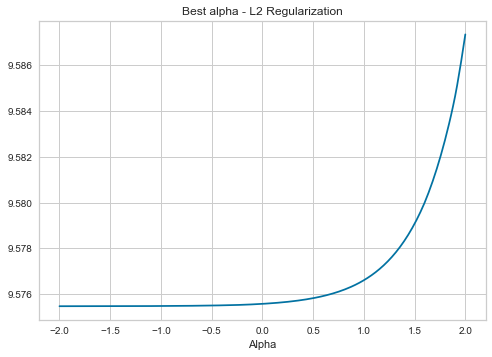

9.575476510090686


In [114]:
## First for the Ridge model I am going to start out by finding the value for alpha

alpha_list_ridge = 10**(np.linspace(-2, 2, 200))
err_vec_val_ridge = np.zeros(len(alpha_list_ridge))
err_vec_train_ridge = np.zeros(len(alpha_list_ridge))

for i, current_alpha in enumerate(alpha_list_ridge):
    r_model = Ridge(alpha=current_alpha)
    r_model.fit(x_train, y_train)
    
    prediction = r_model.predict(x_val)
    err_vec_val_ridge[i] = mae(y_val, prediction)
    
plt.plot(np.log10(alpha_list_ridge), err_vec_val_ridge)
plt.title('Best alpha - L2 Regularization')
plt.xlabel('Alpha')
plt.show()
print(np.min(err_vec_val_ridge))

In [107]:
alpha_ridge = alpha_list_ridge[np.argmin(err_vec_val_ridge)]

In [108]:
## now we model and find coefficents using L2 regularization

ridge = Ridge(alpha=alpha_ridge)
ridge.fit(x_train, y_train)

print('Coefficents for ridge model')
for i in range(len(x_train.columns)):
    print(f'{x.columns[i]}: {ridge.coef_[i]}')

print(f'\nRidge model intercept: {ridge.intercept_}')

Coefficents for ridge model
userscore: 6.856901245756546
runtime: 1.3248980536060881
principle_cast_meta: 2.1111744929010623
supporting_cast_meta: 1.6892197764927195
director_meta: 1.6162484408447206
writer_meta: 1.8478530486345508
producer_meta: 3.5353756925803763
principle_cast_user: -0.3688928227701749
supporting_cast_user: -1.7328717184471096
writers_user: -0.6987764783795263
director_user: -0.3431975760475199
producer_user: -0.8680098772146169
NR: 1.147548971482734
PG13: -0.5474196686588284
genre_drama: 0.7387647157769063
lang_english: -0.3680669532006216

Ridge model intercept: 57.02946941129087


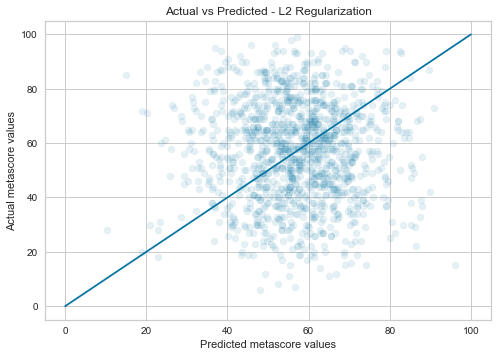

RIDGE MODEL RESULTS
R^2: 0.5115858822083981
Mean Absolute Error: 9.575476510090686


In [126]:
# testing for Ridge

ridge_predict = ridge.predict(x_val)

plt.scatter(ridge_predict, y_test, alpha=.1)
plt.xlabel('Predicted metascore values')
plt.ylabel('Actual metascore values')
plt.title('Actual vs Predicted - L2 Regularization')
plt.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10))
plt.show()

r2_score_ridge = r2_score(y_val, ridge_predict)
mae_ridge = mean_absolute_error(y_val, ridge_predict)

print(f'RIDGE MODEL RESULTS\nR^2: {r2_score_ridge}\nMean Absolute Error: {mae_ridge}')

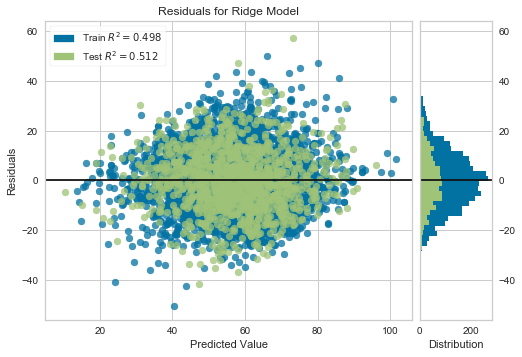

In [110]:
from yellowbrick.regressor import ResidualsPlot

r_model = Ridge()
visualizer = ResidualsPlot(r_model)

visualizer.fit(x_train, y_train)
visualizer.score(x_val, y_val)
visualizer.show()

/Users/seansisler/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



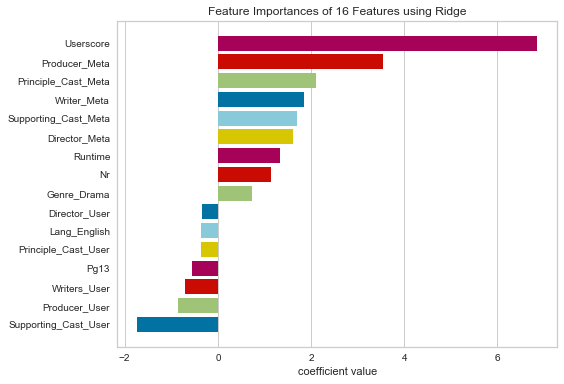

In [111]:
from yellowbrick.model_selection import FeatureImportances

labels = list(map(lambda s: s.title(), x_train.columns))

viz = FeatureImportances(Ridge(), labels=labels, relative=False)

viz.fit(x_train, y_train)
viz.show()

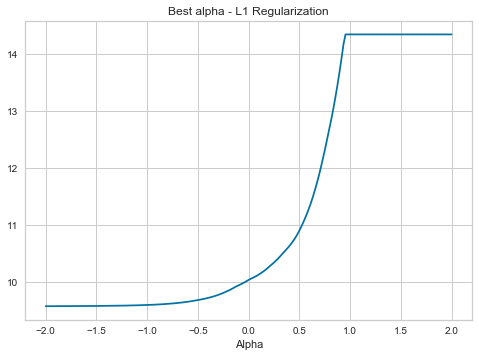

9.577612455144662


In [115]:
## LASSO model
## lastly I'm going to use see how the data performs with L1 Regularization

alpha_list_lasso = 10**(np.linspace(-2, 2, 200))
err_vec_val_lasso = np.zeros(len(alpha_list_lasso))

for i, current_alpha in enumerate(alpha_list_lasso):
    lasso = Lasso(alpha=current_alpha)
    lasso.fit(x_train, y_train)
    predict_lasso = lasso.predict(x_val)
    err_vec_val_lasso[i] = mae(y_val, predict_lasso)

plt.plot(np.log10(alpha_list_lasso), err_vec_val_lasso)
plt.title('Best alpha - L1 Regularization')
plt.xlabel('Alpha')
plt.show()

print(np.min(err_vec_val_lasso))

In [121]:
alpha_lasso = alpha_list_lasso[np.argmin(err_vec_val_lasso)]

lasso = Lasso(alpha=alpha_lasso)

lasso.fit(x_train, y_train)

print('LASSO model coefficients:')
for i in range(len(x_train.columns)):
    print(f'{x_train.columns[i]}: {lasso.coef_[i]}')
    
print(f'\nLASSO model intercept: {lasso.intercept_}')

LASSO model coefficients:
userscore: 6.843722242630239
runtime: 1.3153483430382782
principle_cast_meta: 2.107645556537785
supporting_cast_meta: 1.675641410446962
director_meta: 1.6127287829858605
writer_meta: 1.83915255528547
producer_meta: 3.5338212007051215
principle_cast_user: -0.35671062121410047
supporting_cast_user: -1.7204024795294814
writers_user: -0.6896107618251339
director_user: -0.33790218641629943
producer_user: -0.8579229673078999
NR: 1.1476012755257812
PG13: -0.540214429754872
genre_drama: 0.7355177672573342
lang_english: -0.36336650785600577

LASSO model intercept: 57.028991260213985


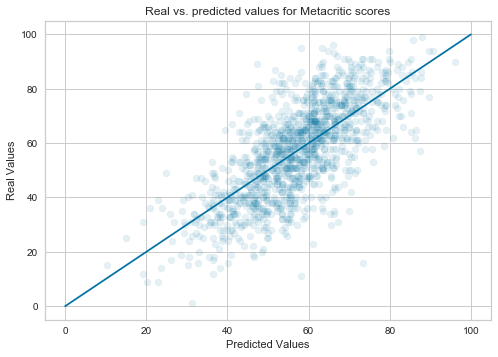

In [124]:
## testing for lasso model 

prediction_lasso = lasso.predict(x_val)

plt.scatter(prediction_lasso, y_val, alpha=.1)
plt.plot(np.linspace(0,100, 10), np.linspace(0, 100, 10))
plt.title('Real vs. predicted values for Metacritic scores')
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
plt.show()

In [128]:
r2_score_lasso = r2_score(y_val, prediction_lasso)
mae_lasso = mean_absolute_error(y_val, prediction_lasso)

print(f'LASSO MODEL RESULTS\nR^2: {r2_score_lasso}\nMean Absolute Error: {mae_lasso}')

LASSO MODEL RESULTS
R^2: 0.511537829897758
Mean Absolute Error: 9.577612455144644


In [132]:
from sklearn.linear_model import lars_path

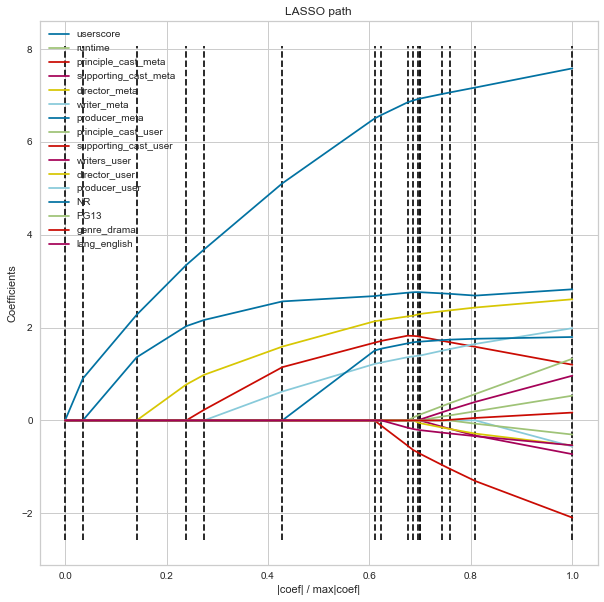

In [133]:
## just to see the LARS path I'm going to compute a regularization path with LARS

alphas, _, coefs = lars_path(x_train.values, y_train.values, method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10, 10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO path')
plt.axis('tight')
plt.legend(x_train.columns)
plt.show()

### Selecting model

In [136]:
print(f'Linear regression (val), OLS, R^2 score: {round(lr.score(x_val, y_val), 6)}')
print(f'Linear regression (test), OLS, R^2 score: {round(lr.score(x_test, y_test), 6)}')
print(f'\nLinear regression (val), with second degree polynomial terms, R^2 score: {round(lr_poly.score(x_val_poly, y_val), 6)}')
print(f'Linear regression (test), with second degree polynomial terms, R^2 score: {round(lr_poly.score(x_test_poly, y_test), 6)}')
print(f'\nLinear regression (val), with L2 regularization (Ridge), R^2 score: {round(ridge.score(x_val, y_val), 6)}')
print(f'Linear regression (test), with L2 regularization (Ridge, R^2 score: {round(ridge.score(x_test, y_test), 6)}')
print(f'\nLinear regression (val), with L1 regularization, R^2 score: {round(lasso.score(x_val, y_val), 6)}')
print(f'Linear regression (test), with L1 regularization, R^2 score: {round(lasso.score(x_test, y_test), 6)}')

Linear regression (val), OLS, R^2 score: 0.511586
Linear regression (test), OLS, R^2 score: 0.522746

Linear regression (val), with second degree polynomial terms, R^2 score: 0.497395
Linear regression (test), with second degree polynomial terms, R^2 score: 0.522141

Linear regression (val), with L2 regularization (Ridge), R^2 score: 0.511586
Linear regression (test), with L2 regularization (Ridge, R^2 score: 0.522746

Linear regression (val), with L1 regularization, R^2 score: 0.511538
Linear regression (test), with L1 regularization, R^2 score: 0.522538


In [138]:
def rmse(prediction, actual):
    return np.sqrt(np.mean((prediction - actual)**2))

In [139]:
lr_test_predict = lr.predict(x_test)
ridge_test_predict = ridge.predict(x_test)
lasso_test_predict = lasso.predict(x_test)

print(f'Root mean squared error for no regularization model: {rmse(lr_test_predict, y_test)}')
print(f'\nRoot mean squared error for L1 regularization model: {rmse(ridge_test_predict, y_test)}')
print(f'\nRoot mean squared error for L2 regularization model: {rmse(lasso_test_predict, y_test)}')

Root mean squared error for no regularization model: 12.581227188493873

Root mean squared error for L1 regularization model: 12.581228797123988

Root mean squared error for L2 regularization model: 12.583970710662221


The OLS model with polynomials had the best improvement in R^2 which makes it a viable option but the R^2 values in the end aren't that different from the OLS model without polynomials. When I did the cross validation, the model without polynomials performed best. 

Ridge, Lasso, and the normal model all performed almost the exact same - while ridge and the OLS model with no regularization did perform basically the same. 

With all three models there is a slight increase in R^2 from the original baseline model before feature selection. I'm going to choose the OLS model with no regularization for my final model. The model with no regularization had the lowest RMSE. 

Final model, OLS (no regularization), R^2 (test set): 0.5227462122544375

Root mean squared error for no regularization model: 12.581227188493873

Final model coefficients:
userscore: 6.856923254543384
runtime: 1.3248995427912105
principle_cast_meta: 2.111175028129378
supporting_cast_meta: 1.6892243125597872
director_meta: 1.6162434499617655
writer_meta: 1.8478539422973161
producer_meta: 3.5353889817939668
principle_cast_user: -0.3688951007344205
supporting_cast_user: -1.732881643314679
writers_user: -0.6987790669436615
director_user: -0.3431955045116088
producer_user: -0.8680207841087729
NR: 1.1475489427493388
PG13: -0.5474190452396872
genre_drama: 0.7387625450210392
lang_english: -0.3680650189241547

Final model intercept: 57.02946940108485


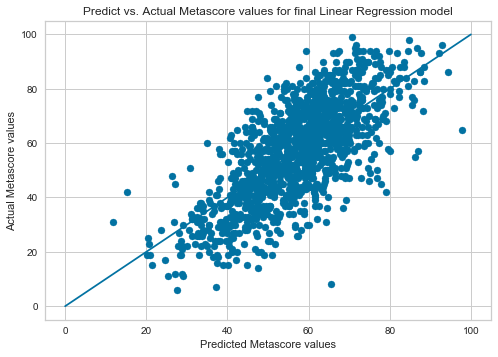

In [158]:
print(f'Final model, OLS (no regularization), R^2 (test set): {lr.score(x_test, y_test)}')
print(f'\nRoot mean squared error for no regularization model: {rmse(lr_test_predict, y_test)}')
print('\nFinal model coefficients:')
for i in range(len(x_train.columns)):
    print(f'{x_train.columns[i]}: {lr.coef_[i]}')
print(f'\nFinal model intercept: {lr.intercept_}')

m, b = np.polyfit(lr_test_predict, y_test, 1)

plt.scatter(lr_test_predict, y_test)
plt.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10))
plt.xlabel('Predicted Metascore values')
plt.ylabel('Actual Metascore values')
plt.title('Predict vs. Actual Metascore values for final Linear Regression model')
plt.show()

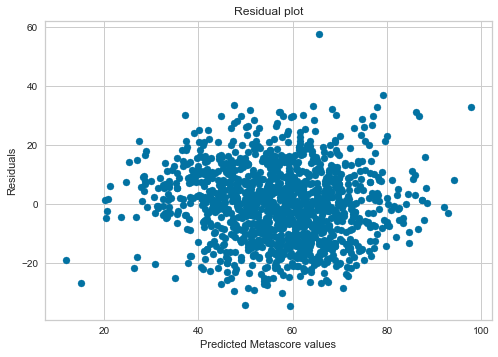

In [169]:
residuals = lr_test_predict - y_test

plt.scatter(lr_test_predict, residuals)
plt.xlabel('Predicted Metascore values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

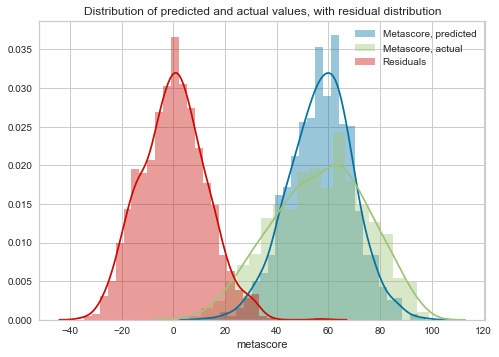

In [170]:
sns.distplot(lr_test_predict, label='Metascore, predicted')
sns.distplot(y_test, label='Metascore, actual')
sns.distplot(residuals, label='Residuals')
plt.legend()
plt.title('Distribution of predicted and actual values, with residual distribution')
plt.show()

In [173]:
x

userscore   runtime  principle_cast_meta  supporting_cast_meta  \
0      0.667810  3.007672            -0.264148              0.373676   
1      1.502848  1.068537             2.171055              2.913565   
2      0.946156 -0.346507             3.199525              4.677419   
3      0.389463  0.177583             0.455051              0.241541   
4      1.224502 -0.660962             3.433755              3.400518   
...         ...       ...                  ...                   ...   
6223   1.015743 -1.394688            -2.443959             -2.006810   
6224  -2.463585 -0.556143             0.017277             -0.123223   
6225  -2.881105 -0.294098            -1.778844             -0.756152   
6226  -2.950691 -1.080234             0.257762              0.986465   
6227  -4.133663  0.125174            -0.201836             -0.687771   

      director_meta  writer_meta  producer_meta  principle_cast_user  \
0         -0.237237     1.299605       0.494773             0.118836   
1          1.960297     1.341928       2.610298             1.961199   
2          1.960297     1.589109       2.078924             2.035997   
3          0.260547     0.277149       1.158229             0.303254   
4          2.418959     2.641789       3.091065             2.137624   
...             ...          ...            ...                  ...   
6223       0.361723    -1.520530      -2.307016             0.024177   
6224      -1.074971    -0.437313      -0.766314             0.980090   
6225      -2.815191    -2.875704      -3.285418            -0.999268   
6226      -0.063215    -0.054730       0.712535             2.523807   
6227       0.213332    -1.714127      -0.020739            -0.457860   

      supporting_cast_user  writers_user  director_user  producer_user  \
0                -0.792776      0.729341       0.169816      -0.039597   
1                 2.760529      1.480450       1.530772       2.391932   
2                 2.760529      1.298597       1.368507       2.216070   
3                 0.077744     -0.683602      -0.731390      -0.334169   
4                 2.588222      1.416801       1.263512       2.005036   
...                    ...           ...            ...            ...   
6223              1.454830      0.625740       0.764787       0.512166   
6224              1.789511      1.116743       0.703540       1.028027   
6225             -1.323278     -3.738734      -3.671245      -4.677707   
6226              2.527505      1.695036       1.557498       2.342691   
6227             -0.399730     -1.992944       0.226688      -1.274924   

            NR      PG13  genre_drama  lang_english  
0    -0.440995 -0.610998     0.902892      0.268913  
1    -0.440995 -0.610998    -1.107552      0.268913  
2    -0.440995 -0.610998     0.902892      0.268913  
3     2.267600 -0.610998     0.902892      0.268913  
4    -0.440995  1.636666     0.902892      0.268913  
...        ...       ...          ...           ...  
6223 -0.440995  1.636666    -1.107552      0.268913  
6224 -0.440995 -0.610998    -1.107552      0.268913  
6225  2.267600 -0.610998    -1.107552      0.268913  
6226 -0.440995 -0.610998     0.902892      0.268913  
6227  2.267600 -0.610998     0.902892      0.268913  

[6228 rows x 16 columns]